# Project Assignment 4: Image Classification System for Indian Bird Species

**Name/Group ID:** Berke Yusuf Uğurlu - Yusuf İpek (Group 6)

**Date:** April 26, 2025

**Course:** BBM 409 - Machine Learning Laboratory

## Introduction

Classification is a fundamental task in machine learning and human cognition. Historically, the ability to classify objects, for instance, as threats or non-threats, was crucial for survival. Modern classification tasks have become more complex and detailed, such as identifying species of animals or plants. As tasks become more detailed, their difficulty increases. To manage these complexities efficiently, we leverage computing machines. Image classification is a significant subfield of this domain. This project focuses on classifying bird species using neural networks and other machine learning techniques.

The aim of this project is to explore various machine learning approaches for classifying bird species from a given dataset. We will start with traditional feature extraction methods coupled with classical machine learning algorithms. Then, we will investigate dimensionality reduction techniques like PCA and other feature selection methods. Subsequently, we will delve into deep learning by fine-tuning pre-trained Convolutional Neural Network (CNN) models and training CNN models from scratch (both with random weights and custom architectures). A key aspect of this project will be extensive experimentation, robust evaluation using multiple metrics (Accuracy, Precision, Recall, F1-Score), and detailed interpretation of the results.

## 1. Dataset Setup

The dataset for this project contains twenty-five species of birds in India, with 1,500 samples for each species. The original samples are separated as 1,200 for training and 300 for validation per species. In total, there are 37,500 images, each approximately 1 MP.

For this assignment, we need to achieve an 80% training, 10% testing, and 10% validation split. We will do this by:
* Using all 1,200 images per species from the original `train` directory as our **training set (80%)**.
* Splitting the 300 images per species from the original `valid` directory randomly in half:
    * 150 images per species for our **new validation set (10%)**.
    * The remaining 150 images per species for our **test set (10%)**.

We will **not** be physically copying these files. Instead, we will generate lists of file paths for each set and use these lists to load data on-the-fly. This approach aligns with the project's allowance to "work with a subset of the dataset" or use it as desired if computational power is a concern, by avoiding unnecessary duplication.

**Dataset Source:** [Kaggle Indian Birds Species Image Classification Dataset](https://www.kaggle.com/datasets/ichhadhari/indian-birds/data)

**Important Considerations from the Assignment:**
* You are free to downscale images if computational resources are a constraint.
* The primary focus is on your interpretations and implementations.

In [37]:
# General Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import cv2 # OpenCV for image processing
from PIL import Image # Pillow for image processing
import random
import time

# Deep Learning Libraries (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("TensorFlow Version:", tf.__version__)
print("NumPy Version:", np.__version__)
print("OpenCV Version:", cv2.__version__)

TensorFlow Version: 2.19.0
NumPy Version: 2.1.3
OpenCV Version: 4.11.0


In [64]:
# --- Dataset Path ---
BASE_DATA_DIR = "Birds_25"

# Check if the dataset path exists
original_train_data_path = os.path.join(BASE_DATA_DIR, "train")
original_valid_data_path = os.path.join(BASE_DATA_DIR, "valid")

print(f"Dataset base directory found at: {BASE_DATA_DIR}")
print(f"Original training data path: {original_train_data_path}")
print(f"Original validation data path: {original_valid_data_path}")

Dataset base directory found at: Birds_25
Original training data path: Birds_25\train
Original validation data path: Birds_25\valid


In [65]:
# --- Function to Prepare File Lists and Labels (80-10-10 split) ---
def prepare_dataset_file_lists():
    train_image_paths = []
    train_labels_str = []
    val_image_paths = []
    val_labels_str = []
    test_image_paths = []
    test_labels_str = []

    species_list = sorted([d for d in os.listdir(original_train_data_path)])
    if not species_list:
        print("No species found in the training directory.")
        return None, None, None, None, None

    print(f"Found {len(species_list)} species: {species_list[:5]}...")
    
    label_encoder = LabelEncoder()
    label_encoder.fit(species_list) # fit on all species names
    class_names = list(label_encoder.classes_)

    for species_name in species_list:
        # training set (80%)
        species_train_dir = os.path.join(original_train_data_path, species_name)
        if os.path.isdir(species_train_dir):
            for img_name in os.listdir(species_train_dir):
                img_path = os.path.join(species_train_dir, img_name)
                if os.path.isfile(img_path):
                    train_image_paths.append(img_path)
                    train_labels_str.append(species_name)
        
        # validation and Test sets (from original 'valid' directory)
        species_original_valid_dir = os.path.join(original_valid_data_path, species_name)
        if os.path.isdir(species_original_valid_dir):
            current_species_original_valid_files = []
            for img_name in os.listdir(species_original_valid_dir):
                img_path = os.path.join(species_original_valid_dir, img_name)
                if os.path.isfile(img_path):
                    current_species_original_valid_files.append(img_path)
            
            random.shuffle(current_species_original_valid_files)
            
            num_original_valid = len(current_species_original_valid_files)
            
            # split each validation set (originally 300) into half (150 val, 150 test)
            split_point = 150 
            if num_original_valid < 300 and num_original_valid > 0:
                print(f"Warning: Species {species_name} has {num_original_valid} images in original validation set (expected 300). Adjusting val/test split point to {num_original_valid // 2}.")
                split_point = num_original_valid // 2
            elif num_original_valid == 0:
                print(f"Warning: Species {species_name} has 0 images in original validation set.")
                continue # no files to split

            val_set_for_species = current_species_original_valid_files[:split_point]
            test_set_for_species = current_species_original_valid_files[split_point : split_point * 2] # haandles cases with <300 
            
            if len(val_set_for_species) == 0 and len(test_set_for_species) == 0 and num_original_valid > 0:
                # fallback - split_point became 0 due to very few images
                if num_original_valid == 1:
                    val_set_for_species = current_species_original_valid_files
                # else leave test empty if only 1 file
            
            val_image_paths.extend(val_set_for_species)
            val_labels_str.extend([species_name] * len(val_set_for_species))
            
            test_image_paths.extend(test_set_for_species)
            test_labels_str.extend([species_name] * len(test_set_for_species))

    # create df
    train_df = pd.DataFrame({'filepath': train_image_paths, 'label': train_labels_str})
    val_df = pd.DataFrame({'filepath': val_image_paths, 'label': val_labels_str})
    test_df = pd.DataFrame({'filepath': test_image_paths, 'label': test_labels_str})
    
    # add numeric labels
    train_df['id'] = label_encoder.transform(train_df['label'])
    val_df['id'] = label_encoder.transform(val_df['label'])
    test_df['id'] = label_encoder.transform(test_df['label'])

    return train_df, val_df, test_df, label_encoder, class_names

In [66]:
# set dataset file lists
train_df, val_df, test_df, label_encoder, class_names = prepare_dataset_file_lists()

print(f"\nDataset prepared:")
print(f"  Training samples: {len(train_df)} (Expected ~{len(class_names)*1200 if class_names else 'N/A'})")
print(f"  Validation samples: {len(val_df)} (Expected ~{len(class_names)*150 if class_names else 'N/A'})")
print(f"  Test samples: {len(test_df)} (Expected ~{len(class_names)*150 if class_names else 'N/A'})")
print(f"  Number of classes: {len(class_names) if class_names else 'N/A'}")
if class_names: print(f"  Example class names: {class_names[:5]}")

# save label encoder classes for later use
np.save('label_encoder_classes.npy', label_encoder.classes_) 

# display first few rows of the df
print("\nTraining DataFrame head:")
print(train_df.head())

print("\nValidation DataFrame head:")
print(val_df.head())

print("\nTest DataFrame head:")
print(test_df.head())

Found 25 species: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna']...

Dataset prepared:
  Training samples: 29999 (Expected ~30000)
  Validation samples: 3750 (Expected ~3750)
  Test samples: 3750 (Expected ~3750)
  Number of classes: 25
  Example class names: [np.str_('Asian-Green-Bee-Eater'), np.str_('Brown-Headed-Barbet'), np.str_('Cattle-Egret'), np.str_('Common-Kingfisher'), np.str_('Common-Myna')]

Training DataFrame head:
                                            filepath                  label  \
0  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   
1  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   
2  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   
3  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   
4  Birds_25\train\Asian-Green-Bee-Eater\Brown-Hea...  Asian-Green-Bee-Eater   

   id  
0   0  
1   0  
2   0  
3   0  

### 1.1. Image Preprocessing Utilities and Data Subsetting
We define a target image size. Images will be loaded and resized on-the-fly.
The assignment allows downscaling images if needed.

In [67]:
# set constants
IMG_WIDTH = 224 
IMG_HEIGHT = 224
IMG_CHANNELS = 3 # color images
TARGET_IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH) # Pillow - (width, height), OpenCV - (height, width)

In [44]:
# --- Pillow Preprocess for Sindgle Image ---
# Pillow - (width, height)
def preprocess_image_pil(image_path, target_size=TARGET_IMG_SIZE, normalize=True):
    try:
        img = Image.open(image_path).convert('RGB') # 3 channels
        img = img.resize((target_size[1], target_size[0])) # PIL resize is (width, height)
        img_array = np.array(img)
        if normalize: # normalization 
            img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path} with PIL: {e}")
        return None

In [77]:
# --- OpenCV PreProcess for Single Image ---
# OpenCV - (height, width)
def preprocess_image_cv2(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH), normalize_for_nn=False, for_feature_extraction=False):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: OpenCV could not read image {image_path}")
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR
        img = cv2.resize(img, (target_size[1], target_size[0])) # cv2 resize is (width, height)
        
        if normalize_for_nn: # normalization
            img_array = img.astype(np.float32) / 255.0
            return img_array
        elif for_feature_extraction: # return as uint8
            return img.astype(np.uint8)
        return img # default return (uint8, RGB)
    except Exception as e:
        print(f"Error processing image {image_path} with CV2: {e}")
        return None

In [69]:
# --- Use a Subset of the DF
# for quick tests
def get_subset_df(df, subset_fraction=0.1, random_state=42):
    if df is None or df.empty or subset_fraction >= 1.0:
        return df
    # Stratified sampling to maintain class proportions in the subset
    # Requires 'id' (numeric label) or 'label' (string label) column for stratification
    group_col = 'id' if 'id' in df.columns else 'label'
    
    # Ensure frac is not too small to result in zero samples for some groups if not replacing
    # A simple way is to ensure at least 1 sample per group if frac is very small, but pandas sample handles this.
    return df.groupby(group_col, group_keys=False).apply(lambda x: x.sample(frac=subset_fraction, random_state=random_state, replace=False))

In [70]:
# GET SUBSET

USE_SUBSET = True # True for development/testing
SUBSET_FRACTION = 0.05 # Fraction of the dataset to use for development/testing

train_df_processed = train_df
val_df_processed = val_df
test_df_processed = test_df

if USE_SUBSET:
    print(f"\nUsing a {SUBSET_FRACTION*100:.0f}% subset of the data for development...")
    train_df_processed = get_subset_df(train_df, SUBSET_FRACTION)
    val_df_processed = get_subset_df(val_df, SUBSET_FRACTION)
    test_df_processed = get_subset_df(test_df, SUBSET_FRACTION) 
    
    print(f"  New Training samples: {len(train_df_processed)}")
    print(f"  New Validation samples: {len(val_df_processed)}")
    print(f"  New Test samples: {len(test_df_processed)}")
else:
    print("\nUsing full prepared dataset splits.")


Using a 5% subset of the data for development...
  New Training samples: 1500
  New Validation samples: 200
  New Test samples: 200


C:\Users\Yusuf İpek\AppData\Local\Temp\ipykernel_25640\3108335365.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(lambda x: x.sample(frac=subset_fraction, random_state=random_state, replace=False))
C:\Users\Yusuf İpek\AppData\Local\Temp\ipykernel_25640\3108335365.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_

### 1.2. Data Visualization
Visualize some sample images and the distribution of classes from our prepared DataFrames.
"Import and visualize the data in any aspects that you think it is beneficial for the reader's better understanding of the data."

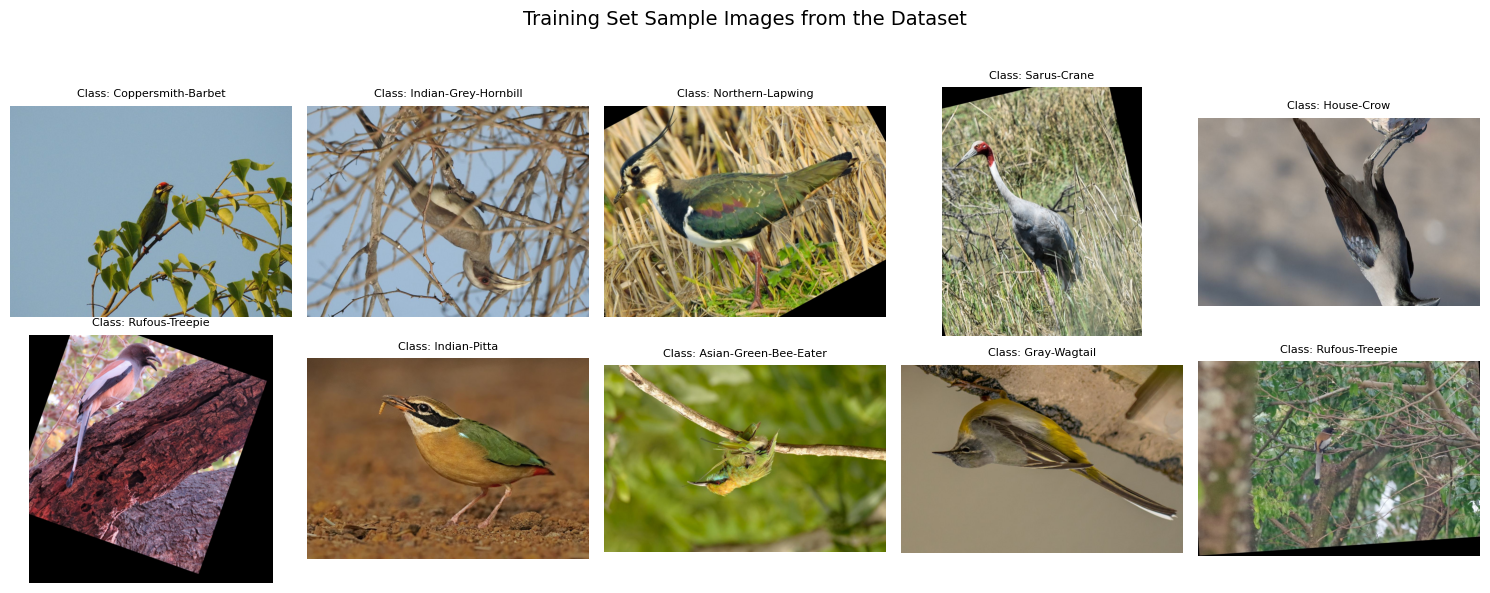

In [71]:
# --- Visualize Sample Images with Pillow from DF ---
def visualize_sample_images_from_df(df, num_samples=10, title_prefix=""):
    if df is None or df.empty:
        print(f"{title_prefix} DataFrame is empty. Cannot visualize samples.")
        return
    
    # Ensure we don't try to sample more than available unique images
    actual_num_samples = min(num_samples, len(df))
    if actual_num_samples == 0: 
        print(f"{title_prefix} DataFrame has no samples to visualize.")
        return
        
    sample_df = df.sample(actual_num_samples)
    
    plt.figure(figsize=(15, max(5, (actual_num_samples//5)*3) ))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = row.filepath
        label_str = row.label
        try:
            img = Image.open(img_path) # Use PIL for consistency with one of the preprocessors
            plt.subplot( (actual_num_samples + 4) // 5 , 5, i + 1)
            plt.imshow(img)
            plt.title(f"Class: {label_str}", fontsize=8)
            plt.axis('off')
        except Exception as e:
            print(f"Could not load image {img_path} for visualization: {e}")
    plt.suptitle(f"{title_prefix} Sample Images from the Dataset", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


visualize_sample_images_from_df(train_df_processed, title_prefix="Training Set")

In [72]:
def plot_class_distribution_from_df(df, title="Class Distribution"):
    if df is None or df.empty:
        print(f"DataFrame for '{title}' is empty. Cannot plot class distribution.")
        return
    
    plt.figure(figsize=(10, 8))
    sns.countplot(data=df, y='label', order = df['label'].value_counts().index, palette='viridis')
    plt.title(title, fontsize=15)
    plt.xlabel("Number of Samples", fontsize=12)
    plt.ylabel("Bird Species", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

C:\Users\Yusuf İpek\AppData\Local\Temp\ipykernel_25640\3086890726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', order = df['label'].value_counts().index, palette='viridis')


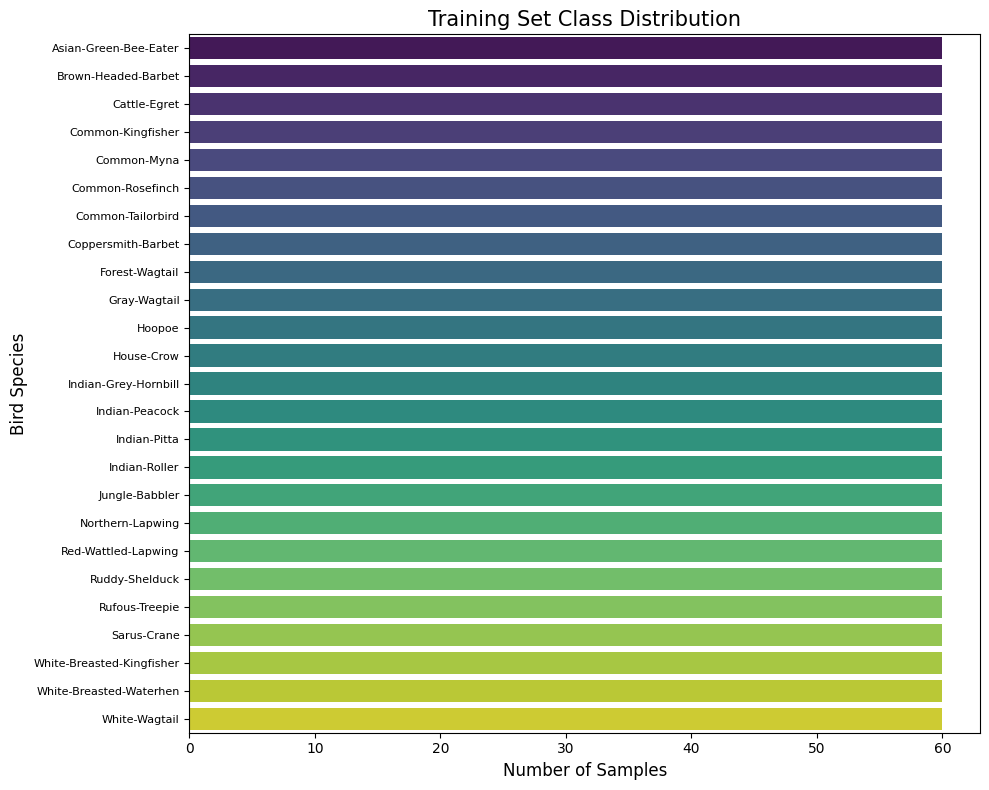

C:\Users\Yusuf İpek\AppData\Local\Temp\ipykernel_25640\3086890726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', order = df['label'].value_counts().index, palette='viridis')


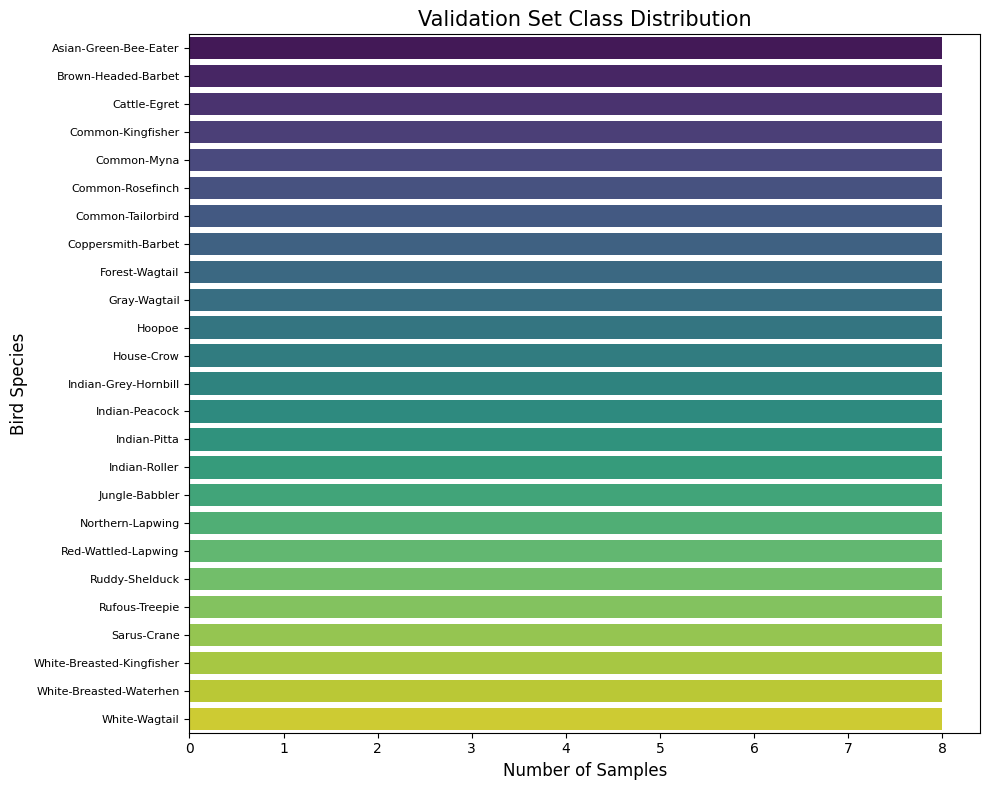

C:\Users\Yusuf İpek\AppData\Local\Temp\ipykernel_25640\3086890726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='label', order = df['label'].value_counts().index, palette='viridis')


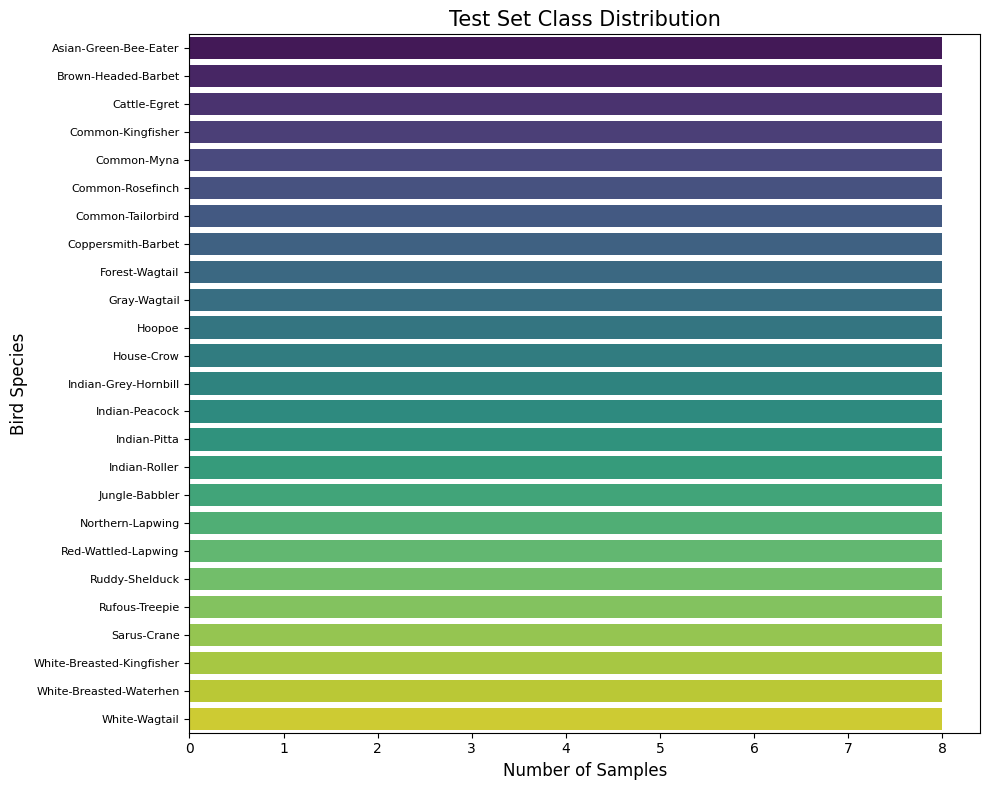

In [73]:
# train
plot_class_distribution_from_df(train_df_processed, title="Training Set Class Distribution")
# value
plot_class_distribution_from_df(val_df_processed, title="Validation Set Class Distribution")
# test
plot_class_distribution_from_df(test_df_processed, title="Test Set Class Distribution")

## Part 1: Classification According to Feature Extraction

In this part, we will extract features from the images and then apply basic Machine Learning (ML) algorithms. We need to try at least three feature extraction methodologies and at least three ML algorithms. Each extracted feature set will be tested with each model separately. Results and comments are required.

**Chosen Feature Extraction Methods:**
1.  **Color Histogram:** Captures color distribution.
2.  **Histogram of Oriented Gradients (HOG):** Captures shape information by edge orientation.
3.  **SIFT (Scale-Invariant Feature Transform) derived features (Aggregated):** Captures local keypoints, aggregated by averaging. (A full Bag of Visual Words would be more robust but is more complex to implement for this scope).

**Chosen ML Algorithms:**
1.  **Support Vector Machines (SVM)**
2.  **Random Forest**
3.  **Multilayer Perceptron (MLP)** (a simple neural network)

Images will be loaded from the file paths in our DataFrames and preprocessed.

In [50]:
# --- Evaluate Model ---
def evaluate_and_log_model(model_name, feature_name, y_true, y_pred, class_names_list, results_accumulator):
    accuracy = accuracy_score(y_true, y_pred)
    # weighted average for precision, recall, F1
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"Results for {model_name} with {feature_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    results_accumulator.append({
        'FeatureSet': feature_name,
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    # Confusion Matrix
    # cm_labels = sorted(np.unique(np.concatenate((y_true, y_pred)))) 
    cm_numeric_labels = np.arange(len(class_names_list)) 

    try:
        cm = confusion_matrix(y_true, y_pred, labels=cm_numeric_labels)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=False, fmt='d', 
                    xticklabels=class_names_list, yticklabels=class_names_list)
        plt.title(f"Confusion Matrix: {model_name} with {feature_name}", fontsize=14)
        plt.xlabel("Predicted Label", fontsize=12)
        plt.ylabel("True Label", fontsize=12)
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()
    except ValueError as ve_cm:
        print(f"Could not plot confusion matrix for {model_name} with {feature_name}: {ve_cm}")
        print("This might happen if y_true or y_pred contain labels not in class_names_list or if subsetting is extreme.")

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

In [78]:
# --- Load and Extract Features DF ---

def load_and_extract_features_from_df(df, feature_extraction_func, image_processor, limit=None):
    """Loads images from filepaths in a DataFrame, extracts features, and returns features and labels."""
    features_list = []
    labels_list = []
    
    paths_to_process = df['filepath'].tolist()
    corresponding_labels = df['id'].tolist() # numeric 'id' for labels

    if limit is not None:
        paths_to_process = paths_to_process[:limit]
        corresponding_labels = corresponding_labels[:limit]
        
    processed_count = 0
    for i, img_path in enumerate(paths_to_process):
        if (i+1) % 200 == 0:
            print(f"  Processing image {i+1}/{len(paths_to_process)} for {feature_extraction_func.__name__}...")
        
        # HOG, SIFT often work on uint8 grayscale. Color Hist on uint8 RGB.
        image = image_processor(img_path, target_size=TARGET_IMG_SIZE, for_feature_extraction=True)
        if image is not None:
            feature_vector = feature_extraction_func(image)
            if feature_vector is not None:
                features_list.append(feature_vector)
                labels_list.append(corresponding_labels[i])
                processed_count += 1
            else: print(f"    Feature extraction failed for {img_path}")
        else: print(f"    Image loading failed for {img_path}")
            
    print(f"  Successfully processed and extracted features for {processed_count}/{len(paths_to_process)} images.")
    if not features_list: # If no features were extracted
        return np.array([]), np.array([])
        
    return np.array(features_list), np.array(labels_list)

In [52]:
# Eesult List and Dicts
part1_results_list = [] # results for comparison table
# all extracted features here for Part 1 & 2
all_extracted_features = {} # example: {'train': {feature_name: (X,y)}, 'val': {} 'test': {}}

#### 1.1. Feature Extraction: Color Histogram
A color histogram represents the distribution of colors in an image. We compute a histogram for each channel (R, G, B) and concatenate them.

In [75]:
# --- Extract Color Histogram for RGB uint8 Image ---
def extract_color_histogram(image, bins=32):
    if image is None: return None
    hist_features = []
    for i in range(image.shape[2]): # iterate over channels (R, G, B)
        channel_hist = cv2.calcHist([image], [i], None, [bins], [0, 256])
        cv2.normalize(channel_hist, channel_hist) # normalize histogram
        hist_features.extend(channel_hist.flatten())
    return np.array(hist_features)

In [79]:
feature_name_ch = 'ColorHistogram'
all_extracted_features['train'] = {}
all_extracted_features['val'] = {}
all_extracted_features['test'] = {}

#  one consistent preprocessor for feature extraction images
image_preprocessor_for_features = preprocess_image_cv2

# training
print(f"Extracting {feature_name_ch} for Training set...")
X_train_ch, y_train_ch = load_and_extract_features_from_df(train_df_processed, extract_color_histogram, image_preprocessor_for_features)
if X_train_ch.size > 0: 
    all_extracted_features['train'][feature_name_ch] = (X_train_ch, y_train_ch)
else: 
    print(f"  No {feature_name_ch} features extracted for training set.")

# validation
print(f"\nExtracting {feature_name_ch} for Validation set...")
X_val_ch, y_val_ch = load_and_extract_features_from_df(val_df_processed, extract_color_histogram, image_preprocessor_for_features)
if X_val_ch.size > 0: 
    all_extracted_features['val'][feature_name_ch] = (X_val_ch, y_val_ch)
else:
    print(f"  No {feature_name_ch} features extracted for validation set.")

# test
print(f"\nExtracting {feature_name_ch} for Test set...")
X_test_ch, y_test_ch = load_and_extract_features_from_df(test_df_processed, extract_color_histogram, image_preprocessor_for_features)
if X_test_ch.size > 0: 
    all_extracted_features['test'][feature_name_ch] = (X_test_ch, y_test_ch)
else:
    print(f"  No {feature_name_ch} features extracted for test set.")

if X_train_ch.size > 0 : 
    print(f"\n{feature_name_ch} feature shapes: Train: {X_train_ch.shape}, Val: {X_val_ch.shape if X_val_ch.size>0 else 'N/A'}, Test: {X_test_ch.shape if X_test_ch.size>0 else 'N/A'}")
else:
    print("Skipping Color Histogram extraction as initial dataframes are not available.")

Extracting ColorHistogram for Training set...
  Processing image 200/1500 for extract_color_histogram...
  Processing image 400/1500 for extract_color_histogram...
  Processing image 600/1500 for extract_color_histogram...
  Processing image 800/1500 for extract_color_histogram...
  Processing image 1000/1500 for extract_color_histogram...
  Processing image 1200/1500 for extract_color_histogram...
  Processing image 1400/1500 for extract_color_histogram...
  Successfully processed and extracted features for 1500/1500 images.

Extracting ColorHistogram for Validation set...
  Processing image 200/200 for extract_color_histogram...
  Successfully processed and extracted features for 200/200 images.

Extracting ColorHistogram for Test set...
  Processing image 200/200 for extract_color_histogram...
  Successfully processed and extracted features for 200/200 images.

ColorHistogram feature shapes: Train: (1500, 96), Val: (200, 96), Test: (200, 96)


#### 1.2. Feature Extraction: Histogram of Oriented Gradients (HOG)
HOG features capture edge or gradient structure. We use `scikit-image`.

In [80]:
from skimage.feature import hog
from skimage import color # exposure not used here directly

# --- Extract HOG Features from RGB Uint8 Image---
def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=8):
    if image is None: return None
    gray_image = color.rgb2gray(image) # skimage converts to float [0,1]
    hog_features_vector = hog(
        gray_image, orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=False,
        transform_sqrt=True)
    return hog_features_vector

In [81]:
feature_name_hog = 'HOG'

# train
print(f"Extracting {feature_name_hog} for Training set...")
X_train_hog, y_train_hog = load_and_extract_features_from_df(train_df_processed, extract_hog_features, image_preprocessor_for_features)
if X_train_hog.size > 0: 
    all_extracted_features['train'][feature_name_hog] = (X_train_hog, y_train_hog)
else: 
    print(f"  No {feature_name_hog} features extracted for training set.")

# validation
print(f"\nExtracting {feature_name_hog} for Validation set...")
X_val_hog, y_val_hog = load_and_extract_features_from_df(val_df_processed, extract_hog_features, image_preprocessor_for_features)
if X_val_hog.size > 0: 
    all_extracted_features['val'][feature_name_hog] = (X_val_hog, y_val_hog)
else: 
    print(f"  No {feature_name_hog} features extracted for validation set.")

# test
print(f"\nExtracting {feature_name_hog} for Test set...")
X_test_hog, y_test_hog = load_and_extract_features_from_df(test_df_processed, extract_hog_features, image_preprocessor_for_features)
if X_test_hog.size > 0:
    all_extracted_features['test'][feature_name_hog] = (X_test_hog, y_test_hog)
else:
    print(f"  No {feature_name_hog} features extracted for test set.")

if X_train_hog.size > 0 : 
    print(f"\n{feature_name_hog} feature shapes: Train: {X_train_hog.shape}, Val: {X_val_hog.shape if X_val_hog.size>0 else 'N/A'}, Test: {X_test_hog.shape if X_test_hog.size>0 else 'N/A'}")
else:
    print("Skipping HOG extraction as initial dataframes are not available.")

Extracting HOG for Training set...
  Processing image 200/1500 for extract_hog_features...
  Processing image 400/1500 for extract_hog_features...
  Processing image 600/1500 for extract_hog_features...
  Processing image 800/1500 for extract_hog_features...
  Processing image 1000/1500 for extract_hog_features...
  Processing image 1200/1500 for extract_hog_features...
  Processing image 1400/1500 for extract_hog_features...
  Successfully processed and extracted features for 1500/1500 images.

Extracting HOG for Validation set...
  Processing image 200/200 for extract_hog_features...
  Successfully processed and extracted features for 200/200 images.

Extracting HOG for Test set...
  Processing image 200/200 for extract_hog_features...
  Successfully processed and extracted features for 200/200 images.

HOG feature shapes: Train: (1500, 1568), Val: (200, 1568), Test: (200, 1568)


#### 1.3. Feature Extraction: SIFT (Aggregated)
SIFT detects local features. We'll aggregate descriptors (e.g., by averaging) for a fixed-size vector.
Ensure `opencv-contrib-python` is installed for SIFT.

In [82]:
# init SIFT detector
sift_detector = None

try:
    sift_detector = cv2.SIFT_create()
except AttributeError:
    print("cv2.SIFT_create() not found. Ensure 'opencv-contrib-python' is installed.")

if sift_detector is not None:
    print("SIFT detector initialized successfully.")

SIFT detector initialized successfully.


In [84]:
MAX_KEYPOINTS_SIFT = 100 # limit keypoints per image if using aggregation
SIFT_DESCRIPTOR_SIZE = 128

# --- Extract SIFT descriptors and Aggregates by averaging with Uint8 RGB Image ---
def extract_sift_features_aggregated(image):
    if image is None or sift_detector is None: return np.zeros(SIFT_DESCRIPTOR_SIZE) # Return zero vector if no image/detector
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # SIFT works on grayscale
    
    keypoints, descriptors = sift_detector.detectAndCompute(gray_image, None)
    
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(SIFT_DESCRIPTOR_SIZE) # Return zero vector if no descriptors found

    # aggregate descriptors: simple averaging
    aggregated_descriptor = np.mean(descriptors, axis=0)
    return aggregated_descriptor.flatten()

In [85]:
feature_name_sift = 'SIFT_Aggregated'

# training
print(f"Extracting {feature_name_sift} for Training set...")
X_train_sift, y_train_sift = load_and_extract_features_from_df(train_df_processed, extract_sift_features_aggregated, image_preprocessor_for_features)
if X_train_sift.size > 0: 
    all_extracted_features['train'][feature_name_sift] = (X_train_sift, y_train_sift)
else: 
    print(f"  No {feature_name_sift} features extracted for training set.")

# validation
print(f"\nExtracting {feature_name_sift} for Validation set...")
X_val_sift, y_val_sift = load_and_extract_features_from_df(val_df_processed, extract_sift_features_aggregated, image_preprocessor_for_features)
if X_val_sift.size > 0:
    all_extracted_features['val'][feature_name_sift] = (X_val_sift, y_val_sift)
else: 
    print(f"  No {feature_name_sift} features extracted for validation set.")

# test
print(f"\nExtracting {feature_name_sift} for Test set...")
X_test_sift, y_test_sift = load_and_extract_features_from_df(test_df_processed, extract_sift_features_aggregated, image_preprocessor_for_features)
if X_test_sift.size > 0:
    all_extracted_features['test'][feature_name_sift] = (X_test_sift, y_test_sift)
else:
    print(f"  No {feature_name_sift} features extracted for test set.")

if X_train_sift.size > 0 : 
    print(f"\n{feature_name_sift} feature shapes: Train: {X_train_sift.shape}, Val: {X_val_sift.shape if X_val_sift.size>0 else 'N/A'}, Test: {X_test_sift.shape if X_test_sift.size>0 else 'N/A'}")
else:
    print("Skipping SIFT Aggregated extraction as SIFT detector is not available or initial dataframes are not available.")

Extracting SIFT_Aggregated for Training set...
  Processing image 200/1500 for extract_sift_features_aggregated...
  Processing image 400/1500 for extract_sift_features_aggregated...
  Processing image 600/1500 for extract_sift_features_aggregated...
  Processing image 800/1500 for extract_sift_features_aggregated...
  Processing image 1000/1500 for extract_sift_features_aggregated...
  Processing image 1200/1500 for extract_sift_features_aggregated...
  Processing image 1400/1500 for extract_sift_features_aggregated...
  Successfully processed and extracted features for 1500/1500 images.

Extracting SIFT_Aggregated for Validation set...
  Processing image 200/200 for extract_sift_features_aggregated...
  Successfully processed and extracted features for 200/200 images.

Extracting SIFT_Aggregated for Test set...
  Processing image 200/200 for extract_sift_features_aggregated...
  Successfully processed and extracted features for 200/200 images.

SIFT_Aggregated feature shapes: Train: 

#### 1.4. Training Machine Learning Models
We train SVM, Random Forest, and MLP on each extracted feature set. Features are scaled for SVM and MLP using a pipeline.

In [88]:
# Model Imports
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import time

In [89]:
# Define the original set of models (for features like Color Histogram, SIFT Aggregated)
models_to_try_part1_standard = {
    "SVM_RBF": Pipeline([
        ('scaler', StandardScaler()),
        # lower-dim features first.
        ('svc', SVC(kernel='rbf', C=1.0, probability=True, random_state=42, class_weight='balanced')) 
    ]),
    "RandomForest_Std": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    "MLP_Std": Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(256, 128), max_iter=500, alpha=0.001, 
            solver='adam', learning_rate_init=0.001, learning_rate='adaptive',
            random_state=42, early_stopping=True, n_iter_no_change=20, verbose=False))
    ])
}

# Define a simplified/faster set of models specifically for HOG features
models_to_try_part1_for_hog = {
    # Linear svc is faster for high-dimensional data like HOG
    "LinearSVC": Pipeline([ 
        ('scaler', StandardScaler()),
        ('svc', LinearSVC(random_state=42, C=0.1, max_iter=2000, dual=True, class_weight='balanced')) 
    ]),
    "RandomForest_Simple": RandomForestClassifier(
        n_estimators=50, max_depth=10, # reduced complexity for HOG
        random_state=42, n_jobs=-1, class_weight='balanced'),
    "MLP_Simple": Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(64,), max_iter=200,
            alpha=0.001, solver='adam', learning_rate_init=0.001,
            random_state=42, early_stopping=True, n_iter_no_change=10, verbose=False))
    ])
}


--- Training models on Feature Set: ColorHistogram ---
Training data shape: X: (1500, 96), y: (1500,)
Test data shape: X: (200, 96), y: (200,)
  Training SVM_RBF (using config: SVM_RBF) with ColorHistogram...
    Training SVM_RBF took 0.63 seconds.
    Test Set Evaluation for SVM_RBF with ColorHistogram:
Results for SVM_RBF with ColorHistogram:
  Accuracy:  0.1400
  Precision: 0.1503
  Recall:    0.1400
  F1-Score:  0.1341


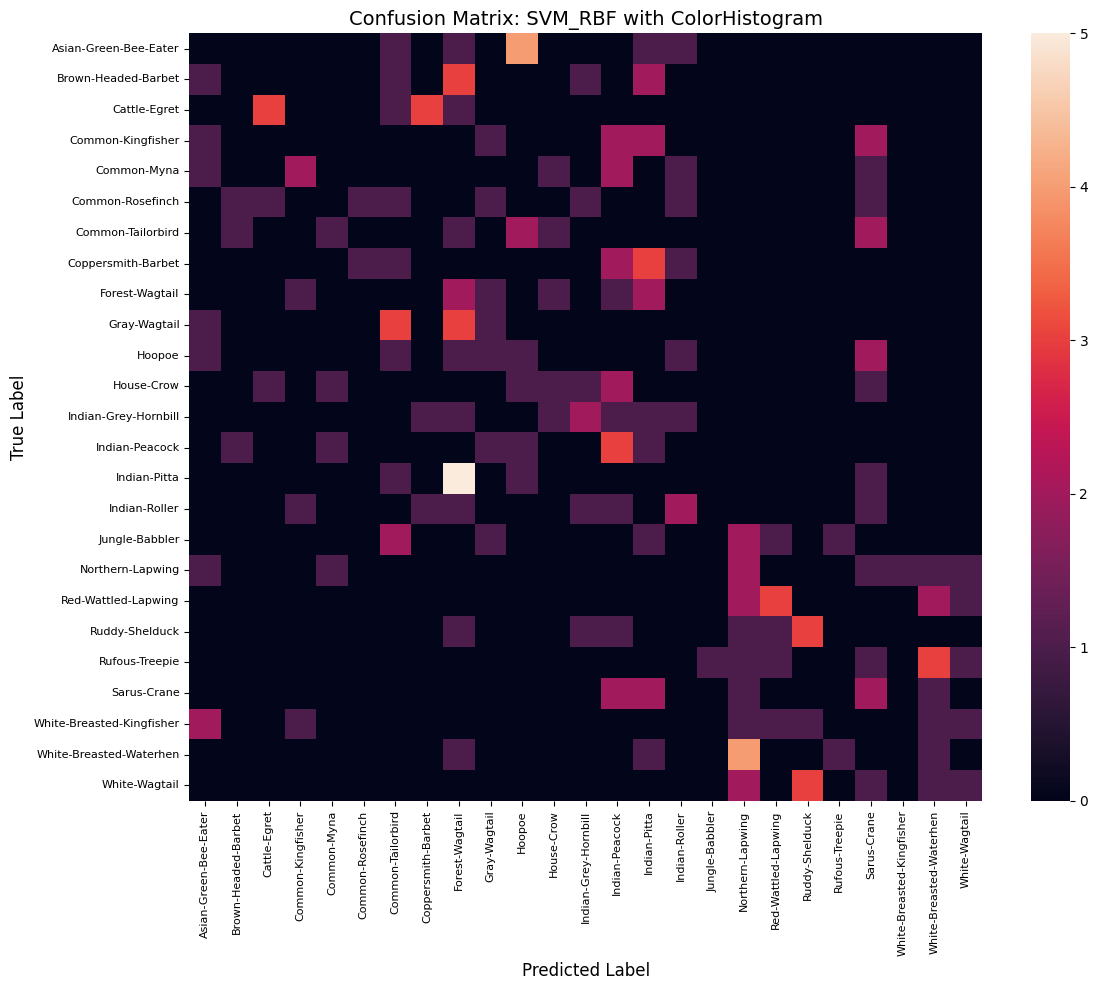

  Training RandomForest (using config: RandomForest_Std) with ColorHistogram...
    Training RandomForest took 0.25 seconds.
    Test Set Evaluation for RandomForest with ColorHistogram:
Results for RandomForest with ColorHistogram:
  Accuracy:  0.1900
  Precision: 0.1816
  Recall:    0.1900
  F1-Score:  0.1778


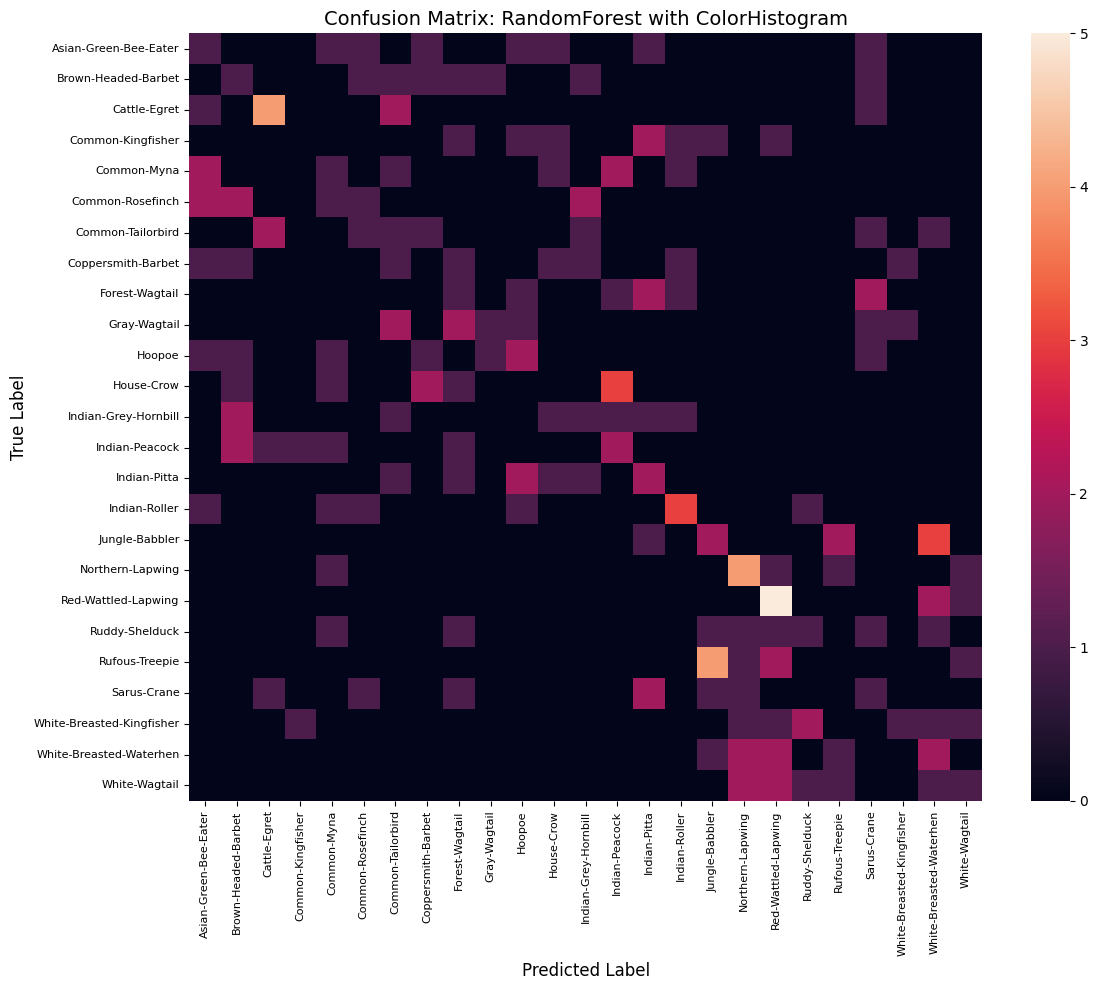

  Training MLP (using config: MLP_Std) with ColorHistogram...
    Training MLP took 0.87 seconds.
    Test Set Evaluation for MLP with ColorHistogram:
Results for MLP with ColorHistogram:
  Accuracy:  0.1600
  Precision: 0.1593
  Recall:    0.1600
  F1-Score:  0.1538


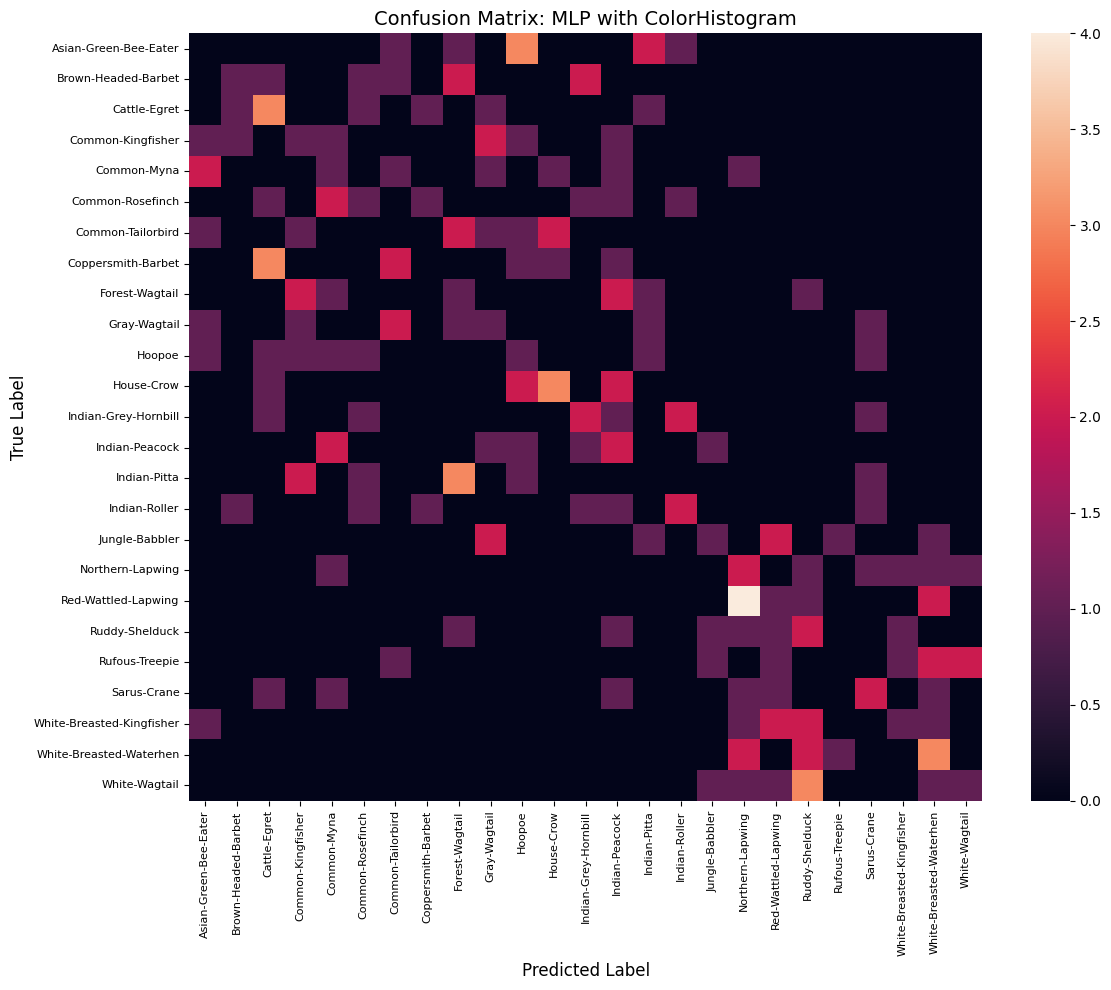


--- Training models on Feature Set: HOG ---
Training data shape: X: (1500, 1568), y: (1500,)
Test data shape: X: (200, 1568), y: (200,)
  Using SIMPLIFIED models for HOG features to manage training time.
  Training LinearSVC (using config: LinearSVC) with HOG...
    Training LinearSVC took 16.86 seconds.
    Test Set Evaluation for LinearSVC with HOG:
Results for LinearSVC with HOG:
  Accuracy:  0.0800
  Precision: 0.0754
  Recall:    0.0800
  F1-Score:  0.0721


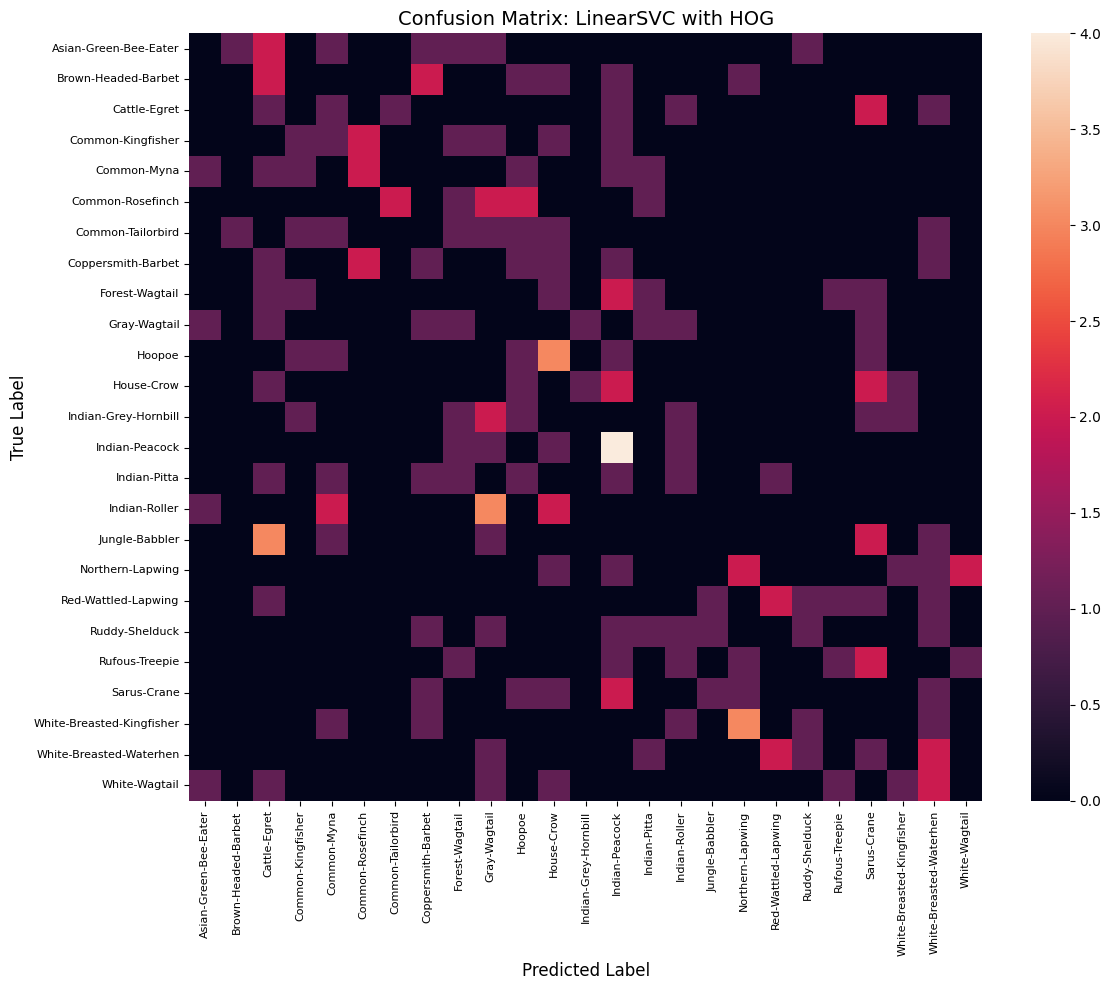

  Training RandomForest_Simple (using config: RandomForest_Simple) with HOG...
    Training RandomForest_Simple took 0.30 seconds.
    Test Set Evaluation for RandomForest_Simple with HOG:
Results for RandomForest_Simple with HOG:
  Accuracy:  0.1100
  Precision: 0.0911
  Recall:    0.1100
  F1-Score:  0.0963


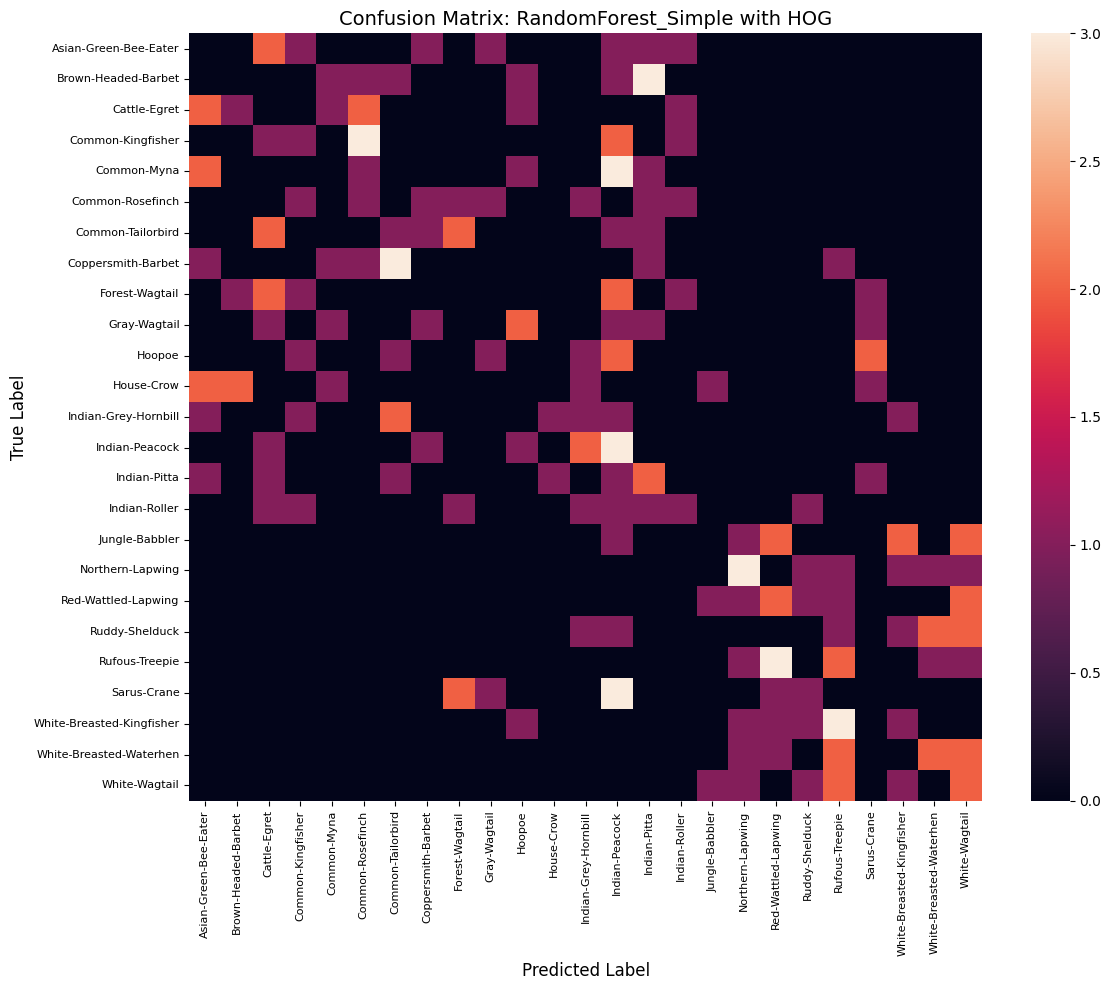

  Training MLP_Simple (using config: MLP_Simple) with HOG...
    Training MLP_Simple took 1.31 seconds.
    Test Set Evaluation for MLP_Simple with HOG:
Results for MLP_Simple with HOG:
  Accuracy:  0.0650
  Precision: 0.0551
  Recall:    0.0650
  F1-Score:  0.0576


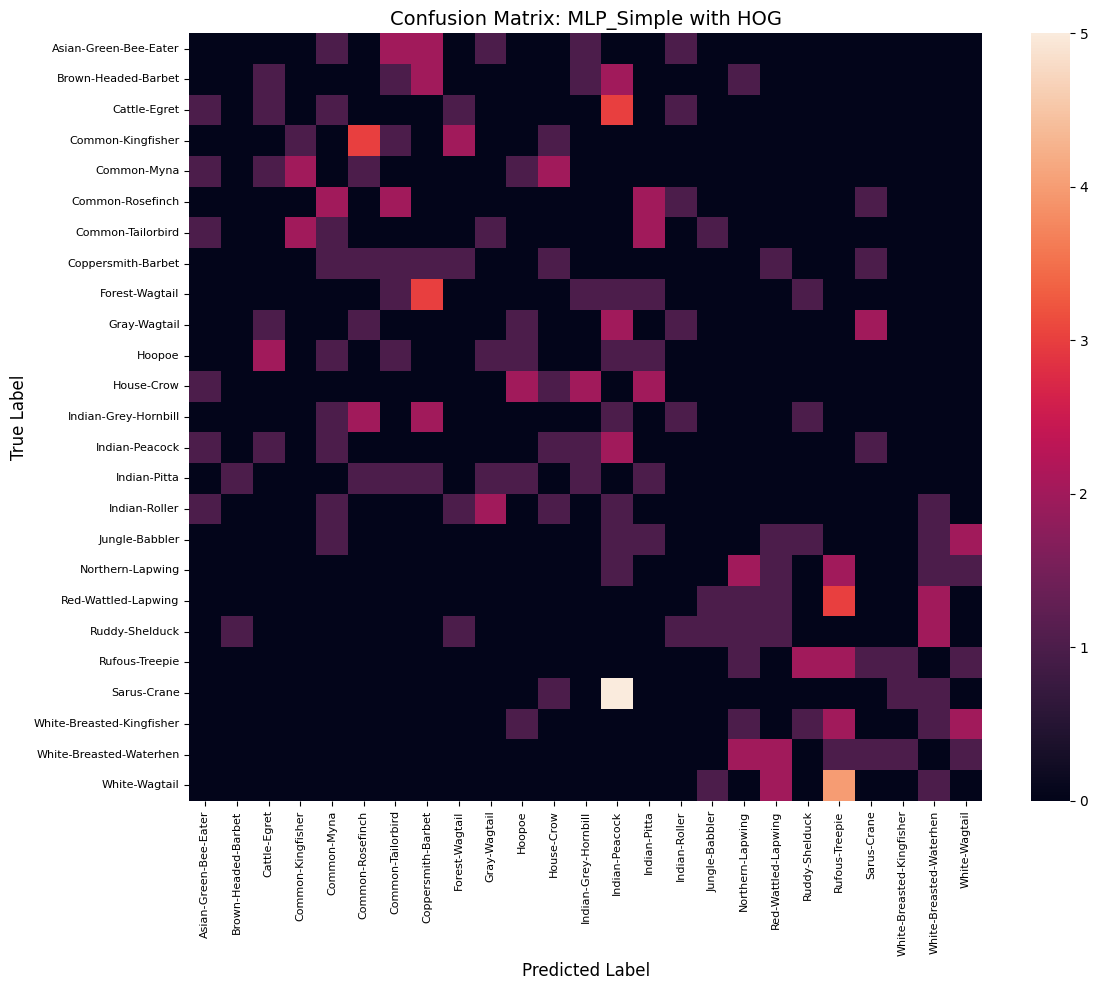


--- Training models on Feature Set: SIFT_Aggregated ---
Training data shape: X: (1500, 128), y: (1500,)
Test data shape: X: (200, 128), y: (200,)
  Training SVM_RBF (using config: SVM_RBF) with SIFT_Aggregated...
    Training SVM_RBF took 0.73 seconds.
    Test Set Evaluation for SVM_RBF with SIFT_Aggregated:
Results for SVM_RBF with SIFT_Aggregated:
  Accuracy:  0.1650
  Precision: 0.1562
  Recall:    0.1650
  F1-Score:  0.1496


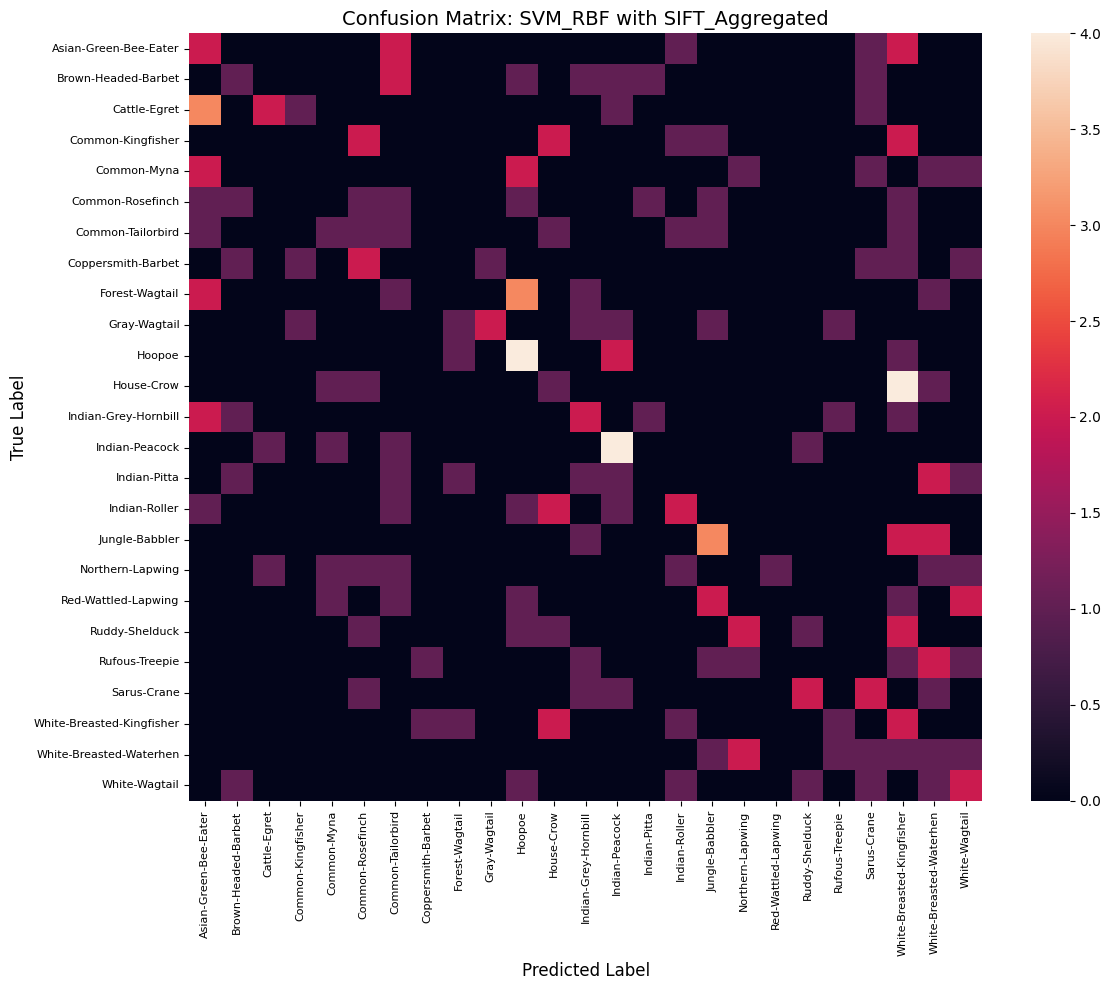

  Training RandomForest (using config: RandomForest_Std) with SIFT_Aggregated...
    Training RandomForest took 0.28 seconds.
    Test Set Evaluation for RandomForest with SIFT_Aggregated:
Results for RandomForest with SIFT_Aggregated:
  Accuracy:  0.1550
  Precision: 0.1425
  Recall:    0.1550
  F1-Score:  0.1440


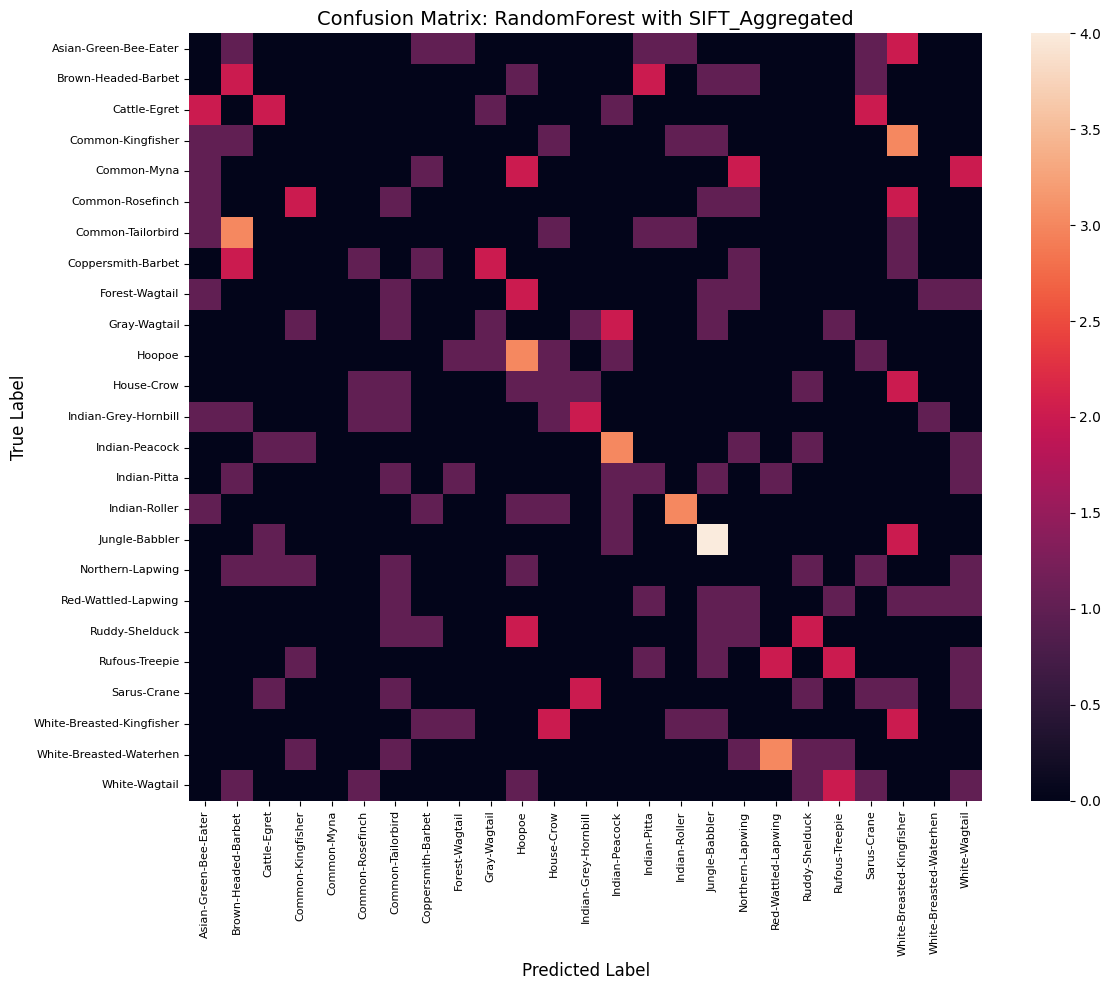

  Training MLP (using config: MLP_Std) with SIFT_Aggregated...
    Training MLP took 1.23 seconds.
    Test Set Evaluation for MLP with SIFT_Aggregated:
Results for MLP with SIFT_Aggregated:
  Accuracy:  0.2050
  Precision: 0.2057
  Recall:    0.2050
  F1-Score:  0.2001


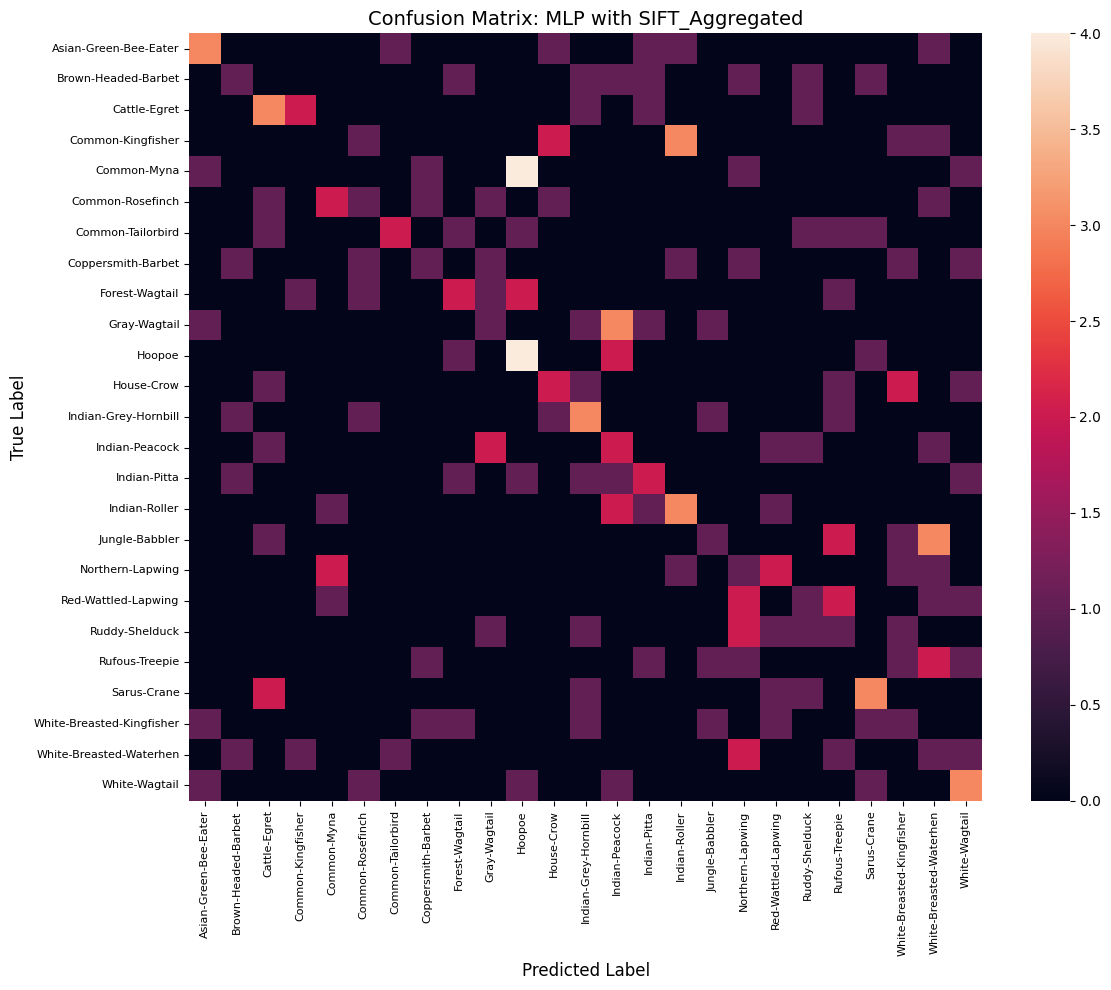

In [92]:
# 
for feature_name_iter, (X_train_feat, y_train_target) in all_extracted_features['train'].items():
    print(f"\n--- Training models on Feature Set: {feature_name_iter} ---")

    if X_train_feat.size == 0 or y_train_target.size == 0:
        print(f"  Skipping {feature_name_iter} as training features or labels are empty.")
        continue

    print(f"Training data shape: X: {X_train_feat.shape}, y: {y_train_target.shape}")

    # test set
    if feature_name_iter not in all_extracted_features.get('test', {}) or all_extracted_features['test'][feature_name_iter][0].size == 0:
        print(f"  Test features for {feature_name_iter} not found or empty. Skipping.")
        continue

    X_test_feat, y_test_target = all_extracted_features['test'][feature_name_iter]
    if X_test_feat.size == 0 or y_test_target.size == 0:
        print(f"  Skipping {feature_name_iter} as test features or labels are empty.")
        continue

    print(f"Test data shape: X: {X_test_feat.shape}, y: {y_test_target.shape}")

    # features are 2D
    if X_train_feat.ndim == 1: 
        X_train_feat = X_train_feat.reshape(-1, 1)
    if X_test_feat.ndim == 1: 
        X_test_feat = X_test_feat.reshape(-1, 1)
        
    # select models
    models_to_run_now = {}
    if feature_name_iter == feature_name_hog: # Use the simplified models for HOG
        print(f"  Using SIMPLIFIED models for HOG features to manage training time.")
        models_to_run_now = models_to_try_part1_for_hog
    else:
        models_to_run_now = models_to_try_part1_standard
    
    for model_name_from_dict, model_pipeline in models_to_run_now.items():
        log_model_name = model_name_from_dict.split('_HOG')[0] if '_HOG' in model_name_from_dict else model_name_from_dict.split('_Std')[0]
        
        print(f"  Training {log_model_name} (using config: {model_name_from_dict}) with {feature_name_iter}...")
        
        start_time = time.time()
        try:
            model_pipeline.fit(X_train_feat, y_train_target)
            end_time = time.time()
            print(f"    Training {log_model_name} took {end_time - start_time:.2f} seconds.")
            
            y_pred_test = model_pipeline.predict(X_test_feat)
            
            print(f"    Test Set Evaluation for {log_model_name} with {feature_name_iter}:")
            # Use the base model name (e.g., "LinearSVC", "SVM") for the results_accumulator
            evaluate_and_log_model(log_model_name, feature_name_iter, y_test_target, y_pred_test, class_names, part1_results_list)
                
        except Exception as e:
            print(f"    ERROR training/evaluating {log_model_name} (config: {model_name_from_dict}) with {feature_name_iter}: {e}")
            import traceback
            traceback.print_exc() # full traceback for debugging



In [93]:
# summary of part 1 results
if part1_results_list:
    part1_results_df = pd.DataFrame(part1_results_list)
    print("\n\n--- Summary of Part 1 Results (Test Set) ---")
    # all columns are displayed
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(part1_results_df)
else:
    print("No models were trained in Part 1, or no results were collected.")



--- Summary of Part 1 Results (Test Set) ---
         FeatureSet                Model  Accuracy  Precision  Recall  F1-Score
0    ColorHistogram              SVM_RBF     0.140   0.150297   0.140  0.134109
1    ColorHistogram         RandomForest     0.190   0.181563   0.190  0.177802
2    ColorHistogram                  MLP     0.160   0.159315   0.160  0.153751
3               HOG            LinearSVC     0.080   0.075401   0.080  0.072140
4               HOG  RandomForest_Simple     0.110   0.091138   0.110  0.096347
5               HOG           MLP_Simple     0.065   0.055113   0.065  0.057580
6   SIFT_Aggregated              SVM_RBF     0.165   0.156226   0.165  0.149570
7   SIFT_Aggregated         RandomForest     0.155   0.142479   0.155  0.143977
8   SIFT_Aggregated                  MLP     0.205   0.205726   0.205  0.200080
9    ColorHistogram              SVM_RBF     0.140   0.150297   0.140  0.134109
10   ColorHistogram         RandomForest     0.190   0.181563   0.190  0.

#### 1.5. Comments on Part 1 Results
*(This section is for your analysis. Fill this in based on the actual results you obtain after running the code. Commenting is as important as experimenting.)*

* **Color Histogram:**
    * Performance with SVM: *(Accuracy, Precision, Recall, F1)*
    * Performance with Random Forest: *(Accuracy, Precision, Recall, F1)*
    * Performance with MLP: *(Accuracy, Precision, Recall, F1)*
    * *Comments:* How well did color histograms perform? Were there significant differences between the models? Why might this be the case? What are the limitations of color histograms for bird classification?

* **HOG Features:**
    * Performance with SVM: *(Accuracy, Precision, Recall, F1)*
    * Performance with Random Forest: *(Accuracy, Precision, Recall, F1)*
    * Performance with MLP: *(Accuracy, Precision, Recall, F1)*
    * *Comments:* Did HOG features improve results compared to color histograms? HOG captures shape; how relevant is this for distinguishing bird species with subtle differences?

* **SIFT (Aggregated) Features:**
    * Performance with SVM: *(Accuracy, Precision, Recall, F1)*
    * Performance with Random Forest: *(Accuracy, Precision, Recall, F1)*
    * Performance with MLP: *(Accuracy, Precision, Recall, F1)*
    * *Comments:* How did the simplified SIFT approach perform? What are the drawbacks of simple aggregation (e.g., averaging)? How might a full Bag of Visual Words (BoVW) model potentially change performance?

* **Overall Comparison for Part 1:**
    * Which feature extraction method generally performed best?
    * Which ML algorithm was most effective with these traditional features?
    * Were results satisfactory for a 25-class problem? Discuss limitations of these feature-based approaches for complex image tasks.
    * Discuss any computational challenges (e.g., time for SIFT, feature vector sizes).

## Part 2: Principal Component Analysis and Feature Selection

Apply PCA and a feature selection method (that eliminates features) to all features extracted in Part 1. Then, try the same ML algorithms as in Part 1. Compare results with Part 1 and within Part 2 approaches.

**Chosen Feature Selection Method (Elimination):**
* **SelectKBest with `f_classif`:** Selects features with the highest ANOVA F-values between label/feature for classification tasks.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

part2_results_list = []
N_COMPONENTS_PCA = 0.95 # Keep components explaining 95% of variance, or set an integer
# For SelectKBest, k can be a fixed number or a percentage. Let's try 50% of original features or a fixed moderate number.
# SIFT aggregated has 128 features, HOG can be large. ColorHist is bins*3.

if not all_extracted_features.get('train') or not all_extracted_features['train']:
    print("No features available from Part 1. Skipping Part 2.")
else:
    for feature_name_iter, (X_train_orig, y_train_orig) in all_extracted_features['train'].items():
        print(f"\n--- Processing Part 2 for Feature Set: {feature_name_iter} ---")
        if X_train_orig.size == 0: 
            print(f"  Skipping {feature_name_iter} as original training features are empty.")
            continue

        # Ensure corresponding val and test sets exist
        if feature_name_iter not in all_extracted_features.get('val', {}) or all_extracted_features['val'][feature_name_iter][0].size == 0 or \
           feature_name_iter not in all_extracted_features.get('test', {}) or all_extracted_features['test'][feature_name_iter][0].size == 0:
            print(f"  Skipping {feature_name_iter} due to missing/empty val/test original features.")
            continue
        
        X_val_orig, y_val_orig = all_extracted_features['val'][feature_name_iter]
        X_test_orig, y_test_orig = all_extracted_features['test'][feature_name_iter]

        # --- 2.1 PCA ---
        print(f"  Applying PCA to {feature_name_iter}...")
        # Scale data before PCA
        scaler_pca = StandardScaler()
        X_train_scaled_pca = scaler_pca.fit_transform(X_train_orig)
        X_val_scaled_pca = scaler_pca.transform(X_val_orig) # Use train's scaler
        X_test_scaled_pca = scaler_pca.transform(X_test_orig)  # Use train's scaler

        # Determine n_components for PCA if it's a float (variance explained)
        # Ensure n_components is less than min(n_samples, n_features)
        current_n_components_pca = N_COMPONENTS_PCA
        if isinstance(N_COMPONENTS_PCA, float) and N_COMPONENTS_PCA < 1.0:
            # If it's a float, it's variance. It will pick components.
            pass 
        elif isinstance(N_COMPONENTS_PCA, int):
             current_n_components_pca = min(N_COMPONENTS_PCA, X_train_scaled_pca.shape[0], X_train_scaled_pca.shape[1])
        else: # Default to a safe number if not float or int
            current_n_components_pca = min(100, X_train_scaled_pca.shape[0], X_train_scaled_pca.shape[1])
        if current_n_components_pca <=0: current_n_components_pca = 1 # must be at least 1 if int specified became 0

        if X_train_scaled_pca.shape[1] < 2: # Not enough features for PCA reduction in some cases
            print(f"    Skipping PCA for {feature_name_iter} as it has < 2 features ({X_train_scaled_pca.shape[1]}). Using scaled original.")
            X_train_pca, X_val_pca, X_test_pca = X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca
        else:
            # If current_n_components_pca (int) is > features, PCA will use n_features
            if isinstance(current_n_components_pca, int) and current_n_components_pca > X_train_scaled_pca.shape[1]:
                current_n_components_pca = X_train_scaled_pca.shape[1]
            
            pca = PCA(n_components=current_n_components_pca, random_state=42)
            try:
                X_train_pca = pca.fit_transform(X_train_scaled_pca)
                X_val_pca = pca.transform(X_val_scaled_pca)
                X_test_pca = pca.transform(X_test_scaled_pca)
                print(f"    PCA applied. Original dim: {X_train_scaled_pca.shape[1]}, Reduced dim: {X_train_pca.shape[1]}")
            except ValueError as e_pca:
                print(f"    Error applying PCA for {feature_name_iter}: {e_pca}. Using scaled original features.")
                X_train_pca, X_val_pca, X_test_pca = X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca
        
        # Train models on PCA-transformed features
        if X_train_pca.size > 0:
            for model_name_iter, model_pipeline in models_to_try_part1_standard.items():
                print(f"    Training {model_name_iter} with {feature_name_iter}_PCA...")
                start_time = time.time()
                try:
                    model_pipeline.fit(X_train_pca, y_train_orig)
                    end_time = time.time()
                    print(f"      Training {model_name_iter} took {end_time - start_time:.2f} seconds.")
                    y_pred_pca = model_pipeline.predict(X_test_pca)
                    evaluate_and_log_model(model_name_iter, f"{feature_name_iter}_PCA", y_test_orig, y_pred_pca, class_names, part2_results_list)
                except Exception as e:
                    print(f"      ERROR training/evaluating {model_name_iter} with {feature_name_iter}_PCA: {e}")
        else:
            print(f"    Skipping model training for {feature_name_iter}_PCA due to empty PCA features.")

        # --- 2.2 Feature Selection (SelectKBest) ---
        print(f"\n  Applying SelectKBest to {feature_name_iter}...")
        num_original_features = X_train_orig.shape[1]
        if num_original_features < 2:
            print(f"    Skipping SelectKBest for {feature_name_iter} as it has < 2 features ({num_original_features}). Using original.")
            X_train_skb, X_val_skb, X_test_skb = X_train_orig, X_val_orig, X_test_orig
        else:
            k_features = max(1, min(num_original_features // 2, 100)) # e.g., 50% of features, capped at 100, at least 1
            if num_original_features <= k_features: # if already few features, use all
                print(f"    Number of features ({num_original_features}) is less than or equal to k={k_features}. Using all original features for SKB step.")
                X_train_skb, X_val_skb, X_test_skb = X_train_orig, X_val_orig, X_test_orig 
            else:
                selector_skb = SelectKBest(score_func=f_classif, k=k_features)
                try:
                    X_train_skb = selector_skb.fit_transform(X_train_orig, y_train_orig)
                    X_val_skb = selector_skb.transform(X_val_orig)
                    X_test_skb = selector_skb.transform(X_test_orig)
                    print(f"    SelectKBest applied. Original dim: {num_original_features}, Reduced dim: {X_train_skb.shape[1]}")
                except ValueError as e_skb:
                    print(f"    Error applying SelectKBest for {feature_name_iter}: {e_skb}. Using original features.")
                    X_train_skb, X_val_skb, X_test_skb = X_train_orig, X_val_orig, X_test_orig

        # Train models on SelectKBest-transformed features
        if X_train_skb.size > 0:
            for model_name_iter, model_pipeline in models_to_try_part1_standard.items():
                print(f"    Training {model_name_iter} with {feature_name_iter}_SelectKBest...")
                start_time = time.time()
                try:
                    model_pipeline.fit(X_train_skb, y_train_orig)
                    end_time = time.time()
                    print(f"      Training {model_name_iter} took {end_time - start_time:.2f} seconds.")
                    y_pred_skb = model_pipeline.predict(X_test_skb)
                    evaluate_and_log_model(model_name_iter, f"{feature_name_iter}_SelectKBest", y_test_orig, y_pred_skb, class_names, part2_results_list)
                except Exception as e:
                    print(f"      ERROR training/evaluating {model_name_iter} with {feature_name_iter}_SelectKBest: {e}")
        else:
            print(f"    Skipping model training for {feature_name_iter}_SelectKBest due to empty features.")

# Display summary of Part 2 results
if part2_results_list:
    part2_results_df = pd.DataFrame(part2_results_list)
    print("\n\n--- Summary of Part 2 Results (Test Set) ---")
    print(part2_results_df.to_string())
else:
    print("No models were trained in Part 2, or no results were collected.")

#### 2.3. Comments on Part 2 Results
*(This section is for your analysis. Fill this in based on actual results. Compare results of these two approaches (PCA, SelectKBest) with each other and with Part 1.)*

* **PCA Performance:**
    * For Color Histograms + PCA: *(Discuss model performances)*
    * For HOG + PCA: *(Discuss model performances)*
    * For SIFT (Aggregated) + PCA: *(Discuss model performances)*
    * *Comments:* How did PCA affect the performance for each feature type and model? Did dimensionality reduction help improve speed or accuracy, or did it hurt? How many principal components were typically selected and how much variance did they explain?

* **SelectKBest Performance:**
    * For Color Histograms + SelectKBest: *(Discuss model performances)*
    * For HOG + SelectKBest: *(Discuss model performances)*
    * For SIFT (Aggregated) + SelectKBest: *(Discuss model performances)*
    * *Comments:* How did SelectKBest perform compared to PCA and raw features? Did eliminating features improve results or training time? What was the impact of the chosen `k` value?

* **Overall Comparison for Part 2:**
    * Compare PCA vs. SelectKBest: Which method was generally more beneficial or detrimental?
    * Compare Part 2 (PCA/SelectKBest) vs. Part 1 (Raw Features): Did these dimensionality reduction/feature selection techniques lead to better overall models in terms of accuracy, F1-score, or training efficiency? Explain your reasoning.
    * Discuss any changes in model behavior or sensitivity after applying these techniques.

## Part 3: Fine-Tuning Pretrained CNN Models

Select at least three well-known pretrained CNN models and fine-tune them for the bird dataset. Report results, loss graphs, and decide where to stop training.

**Chosen Pretrained Models:**
1.  **VGG16**
2.  **ResNet50**
3.  **EfficientNetB0** (Known for good balance of accuracy and efficiency)

We will use `ImageDataGenerator.flow_from_dataframe` to feed images from our prepared DataFrames.

In [ ]:
# Part 3: Fine-Tuning Pretrained CNN Models - SETUP CELL

# --- Preliminary Checks (Ensure these variables are available from previous parts) ---
print("--- Running Preliminary Checks for Part 3 Data Generators ---")
# Ensure critical DataFrames are defined and valid
if 'train_df_processed' not in globals() or train_df_processed is None or train_df_processed.empty:
    print("ERROR: train_df_processed is not defined, None, or empty!")
    # Optionally, raise an error or stop if this is critical for proceeding
    # raise ValueError("train_df_processed is missing or empty. Cannot proceed with CNN model training.")
else:
    print(f"train_df_processed shape: {train_df_processed.shape}")
    if not all(col in train_df_processed.columns for col in ['filepath', 'label']):
        print("ERROR: train_df_processed is missing 'filepath' or 'label' columns.")
        # raise ValueError("train_df_processed is missing 'filepath' or 'label' columns.")

if 'val_df_processed' not in globals() or val_df_processed is None or val_df_processed.empty:
    print("ERROR: val_df_processed is not defined, None, or empty!")
    # raise ValueError("val_df_processed is missing or empty.")
else:
     if not all(col in val_df_processed.columns for col in ['filepath', 'label']):
        print("ERROR: val_df_processed is missing 'filepath' or 'label' columns.")

# Ensure class_names and NUM_CLASSES are correctly defined
if 'class_names' not in globals() or not class_names:
    print("CRITICAL: class_names not defined or empty. Attempting to load or using fallback.")
    try:
        class_names = list(np.load('label_encoder_classes.npy', allow_pickle=True))
        NUM_CLASSES = len(class_names)
        if NUM_CLASSES == 0: raise ValueError("Loaded class_names is empty.")
        print(f"Loaded class_names. NUM_CLASSES = {NUM_CLASSES}")
    except Exception as e:
        print(f"Could not load class_names: {e}. Using fallback NUM_CLASSES = 25.")
        NUM_CLASSES = 25 
        class_names = [f"class_{i}" for i in range(NUM_CLASSES)] 
else:
    NUM_CLASSES = len(class_names)
    print(f"Using existing class_names. NUM_CLASSES = {NUM_CLASSES}")

if NUM_CLASSES == 0:
    raise ValueError("NUM_CLASSES is 0. Cannot proceed with generator creation.")

# Image readability check (optional here, but good practice if not done before)
# print("Checking a few sample image paths from train_df_processed for readability...")
# sample_paths = train_df_processed['filepath'].sample(min(3, len(train_df_processed))).tolist()
# for path in sample_paths:
#     try:
#         img = Image.open(path); img.verify(); img_reopened = Image.open(path); img_reopened.load()
#     except Exception as e:
#         print(f"  WARNING: Potential issue reading image {path} -> {e}")
print("--- Preliminary Checks Done ---")


# --- CNN Constants and Setup ---
BATCH_SIZE_CNN = 32 # Adjust based on your GPU memory
EPOCHS_FT_HEAD = 25      
EPOCHS_FT_FULL = 15  

# Initialize lists/dictionaries for storing results and histories for this Part
part3_results_list = []
cnn_model_histories = {} 

# --- Data Generator Setup ---
train_generator_cnn = None
validation_generator_cnn = None
test_generator_cnn = None

# Define Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Ensure TARGET_IMG_SIZE is defined (e.g., from Part 1 image preprocessing)
if 'TARGET_IMG_SIZE' not in globals():
    print("ERROR: TARGET_IMG_SIZE is not defined. Setting to (224,224) for (height, width).")
    IMG_HEIGHT, IMG_WIDTH = 224, 224 # Define if not globally available
    TARGET_IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH) 

common_flow_params = {
    'x_col': 'filepath',
    'y_col': 'label',
    'target_size': TARGET_IMG_SIZE, 
    'batch_size': BATCH_SIZE_CNN,
    'class_mode': 'categorical', 
    'seed': 42,
    'classes': class_names # Crucial for mapping string labels to consistent integer indices
}

# Helper function to diagnose generator objects (from previous debugging)
def diagnose_generator_attributes(gen_obj, name="Generator"):
    if gen_obj:
        # print(f"Diagnostics for {name}:") # Can be verbose
        # print(f"  Type: {type(gen_obj)}")
        num_samples = getattr(gen_obj, 'n', getattr(gen_obj, 'samples', 'N/A'))
        # print(f"  Samples (n or samples): {num_samples}")
        # print(f"  (Attribute '.num_classes' on iterator object: {getattr(gen_obj, 'num_classes', 'Not present/N/A')})") # Known to be missing
        # print(f"  Filenames count: {len(getattr(gen_obj, 'filenames', []))}")
        # print(f"  Class indices count: {len(getattr(gen_obj, 'classes', []))}")
    else:
        print(f"{name} is None.")

# Updated validation function based on previous findings
def is_generator_now_considered_valid(gen_obj, name="Generator"):
    if gen_obj:
        num_actual_samples = getattr(gen_obj, 'n', getattr(gen_obj, 'samples', 0))
        if num_actual_samples > 0:
            # print(f"INFO: {name} created and reports {num_actual_samples} samples. Will rely on predefined NUM_CLASSES ({NUM_CLASSES}).")
            return True
        else:
            print(f"ERROR: {name} created, but reports 0 samples or 'n'/'samples' attribute missing/invalid.")
            diagnose_generator_attributes(gen_obj, name) 
            return False
    else:
        print(f"ERROR: {name} is None (was not created).")
        return False

# Create Train Generator
try:
    print("\nAttempting to create train_generator_cnn...")
    if train_df_processed is not None and not train_df_processed.empty:
        train_generator_cnn = train_datagen.flow_from_dataframe(
            dataframe=train_df_processed,
            shuffle=True,
            **common_flow_params
        ) 
        if not is_generator_now_considered_valid(train_generator_cnn, "Train Generator"):
            print("Train generator failed validation.")
            train_generator_cnn = None 
        else:
            print(f"Train generator: {getattr(train_generator_cnn, 'n', 'N/A')} samples.")
    else:
        print("train_df_processed is empty or None. Skipping train_generator_cnn.")
except Exception as e_train_gen:
    print(f"EXCEPTION during train_generator_cnn creation: {e_train_gen}")
    import traceback
    traceback.print_exc()
    train_generator_cnn = None

# Create Validation Generator
try:
    print("\nAttempting to create validation_generator_cnn...")
    if val_df_processed is not None and not val_df_processed.empty:
        validation_generator_cnn = val_test_datagen.flow_from_dataframe(
            dataframe=val_df_processed,
            shuffle=False,
            **common_flow_params
        )
        if not is_generator_now_considered_valid(validation_generator_cnn, "Validation Generator"):
            print("Validation generator failed validation.")
            validation_generator_cnn = None
        else:
            print(f"Validation generator: {getattr(validation_generator_cnn, 'n', 'N/A')} samples.")
    else:
        print("val_df_processed is empty or None. Skipping validation_generator_cnn.")
        validation_generator_cnn = None
except Exception as e_val_gen:
    print(f"EXCEPTION during validation_generator_cnn creation: {e_val_gen}")
    import traceback
    traceback.print_exc()
    validation_generator_cnn = None

# Create Test Generator
try:
    print("\nAttempting to create test_generator_cnn...")
    if test_df_processed is not None and not test_df_processed.empty:
        test_generator_cnn = val_test_datagen.flow_from_dataframe(
            dataframe=test_df_processed,
            shuffle=False,
            **common_flow_params
        )
        if not is_generator_now_considered_valid(test_generator_cnn, "Test Generator"):
            print("Test generator failed validation.")
            test_generator_cnn = None
        else:
            print(f"Test generator: {getattr(test_generator_cnn, 'n', 'N/A')} samples.")
    else:
        print("test_df_processed is empty or None. Skipping test_generator_cnn.")
        test_generator_cnn = None
except Exception as e_test_gen:
    print(f"EXCEPTION during test_generator_cnn creation: {e_test_gen}")
    import traceback
    traceback.print_exc()
    test_generator_cnn = None

# --- Helper function for plotting training history ---
def plot_training_history(history, model_name_str):
    """Plots accuracy and loss for training and validation sets."""
    if not history or not hasattr(history, 'history') or not history.history:
        print(f"No history data to plot for {model_name_str}.")
        return
        
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    if not acc or not val_acc or not loss or not val_loss:
        print(f"History object for {model_name_str} is missing one or more required keys (accuracy, val_accuracy, loss, val_loss).")
        print(f"Available keys: {list(history.history.keys())}")
        return

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name_str} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name_str} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

# Final check to inform the user if proceeding to training is safe
print("\n--- Data Generator Creation Summary for Part 3 ---")
if train_generator_cnn and validation_generator_cnn:
    print("INFO: Train and Validation generators appear to be created and have samples.")
    print(f"  Using NUM_CLASSES = {NUM_CLASSES} (derived from LabelEncoder) for all model definitions.")
    print(f"  Train generator samples: {getattr(train_generator_cnn, 'n', getattr(train_generator_cnn, 'samples', 'N/A'))}")
    print(f"  Validation generator samples: {getattr(validation_generator_cnn, 'n', getattr(validation_generator_cnn, 'samples', 'N/A'))}")
    if test_generator_cnn:
        print(f"  Test generator samples: {getattr(test_generator_cnn, 'n', getattr(test_generator_cnn, 'samples', 'N/A'))}")
    else:
        print("  Test generator was not created or failed validation.")
    print("Proceeding to CNN model training cells (Part 3.1 onwards) should be OK if sample counts are > 0.")
else:
    print("CRITICAL ERROR: One or both of Train/Validation Keras data generators FAILED to initialize properly or are empty. CNN training CANNOT proceed safely.")

### 3.1 Fine-tuning VGG16

In [ ]:
if train_generator_cnn is not None and validation_generator_cnn is not None and NUM_CLASSES > 0:
    base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    base_model_vgg16.trainable = False # Freeze base model initially

    model_vgg16 = Sequential([
        base_model_vgg16,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')
    ], name="VGG16_FineTuned")

    model_vgg16.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    
    print("VGG16 Model Summary (Head Training):")
    model_vgg16.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    # Train the head
    print("\nTraining VGG16 head...")
    history_vgg16_head = model_vgg16.fit(
        train_generator_cnn,
        epochs=EPOCHS_FT_HEAD,
        validation_data=validation_generator_cnn,
        callbacks=[early_stopping]
    )
    cnn_model_histories['VGG16_Head'] = history_vgg16_head
    plot_training_history(history_vgg16_head, "VGG16 (Head Fine-Tuned)")

    # Unfreeze some layers of VGG16 for further fine-tuning
    base_model_vgg16.trainable = True
    fine_tune_at = 15 # VGG16 has 19 layers in base (block5_conv1 is layer index 14, so unfreeze from here)
    for layer in base_model_vgg16.layers[:fine_tune_at]:
        layer.trainable = False

    model_vgg16.compile(optimizer=Adam(learning_rate=1e-5), # Lower learning rate for full fine-tuning
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    
    print("\nVGG16 Model Summary (Full Fine-Tuning):")
    # model_vgg16.summary() # Can be very long, optional

    print("\nFine-tuning VGG16 (more layers)...")
    # Calculate initial_epoch correctly for continued training
    initial_epoch_full_ft = 0
    if history_vgg16_head and history_vgg16_head.epoch:
        initial_epoch_full_ft = history_vgg16_head.epoch[-1] + 1
        
    history_vgg16_full = model_vgg16.fit(
        train_generator_cnn,
        epochs=initial_epoch_full_ft + EPOCHS_FT_FULL,
        initial_epoch=initial_epoch_full_ft,
        validation_data=validation_generator_cnn,
        callbacks=[early_stopping]
    )
    cnn_model_histories['VGG16_FullFT'] = history_vgg16_full
    plot_training_history(history_vgg16_full, "VGG16 (Full Fine-Tuned)")
    
    # Evaluate VGG16
    if test_generator_cnn:
        print("\nEvaluating VGG16 (Fine-Tuned) on Test Set...")
        vgg16_loss, vgg16_accuracy = model_vgg16.evaluate(test_generator_cnn)
        print(f"VGG16 Test Accuracy: {vgg16_accuracy:.4f}, Test Loss: {vgg16_loss:.4f}")
        y_pred_vgg16_probs = model_vgg16.predict(test_generator_cnn)
        y_pred_vgg16 = np.argmax(y_pred_vgg16_probs, axis=1)
        evaluate_and_log_model("VGG16_FineTuned", "CNN_TransferLearn", test_generator_cnn.classes, y_pred_vgg16, class_names, part3_results_list)
    else:
        print("Test generator not available. Skipping VGG16 evaluation.")
else:
    print("Skipping VGG16 fine-tuning as data generators or class info are not available.")

### 3.2 Fine-tuning ResNet50

In [ ]:
if train_generator_cnn is not None and validation_generator_cnn is not None and NUM_CLASSES > 0:
    base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    base_model_resnet50.trainable = False 

    model_resnet50 = Sequential([
        base_model_resnet50,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(), 
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')
    ], name="ResNet50_FineTuned")

    model_resnet50.compile(optimizer=Adam(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    print("ResNet50 Model Summary (Head Training):")
    model_resnet50.summary()

    early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    print("\nTraining ResNet50 head...")
    history_resnet50_head = model_resnet50.fit(
        train_generator_cnn,
        epochs=EPOCHS_FT_HEAD,
        validation_data=validation_generator_cnn,
        callbacks=[early_stopping_resnet]
    )
    cnn_model_histories['ResNet50_Head'] = history_resnet50_head
    plot_training_history(history_resnet50_head, "ResNet50 (Head Fine-Tuned)")

    # Unfreeze some layers of ResNet50
    base_model_resnet50.trainable = True
    fine_tune_at_resnet = 140 # Example: unfreeze layers from conv5_block1_out onwards (ResNet50 has ~170 layers)
    for layer in base_model_resnet50.layers[:fine_tune_at_resnet]:
        layer.trainable = False
    
    model_resnet50.compile(optimizer=Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    # print("\nResNet50 Model Summary (Full Fine-Tuning):") # Optional: Can be very long
    # model_resnet50.summary()

    print("\nFine-tuning ResNet50 (more layers)...")
    initial_epoch_full_ft_resnet = 0
    if history_resnet50_head and history_resnet50_head.epoch:
        initial_epoch_full_ft_resnet = history_resnet50_head.epoch[-1] + 1
        
    history_resnet50_full = model_resnet50.fit(
        train_generator_cnn,
        epochs=initial_epoch_full_ft_resnet + EPOCHS_FT_FULL,
        initial_epoch=initial_epoch_full_ft_resnet,
        validation_data=validation_generator_cnn,
        callbacks=[early_stopping_resnet]
    )
    cnn_model_histories['ResNet50_FullFT'] = history_resnet50_full
    plot_training_history(history_resnet50_full, "ResNet50 (Full Fine-Tuned)")

    if test_generator_cnn:
        print("\nEvaluating ResNet50 (Fine-Tuned) on Test Set...")
        resnet50_loss, resnet50_accuracy = model_resnet50.evaluate(test_generator_cnn)
        print(f"ResNet50 Test Accuracy: {resnet50_accuracy:.4f}, Test Loss: {resnet50_loss:.4f}")
        y_pred_resnet50_probs = model_resnet50.predict(test_generator_cnn)
        y_pred_resnet50 = np.argmax(y_pred_resnet50_probs, axis=1)
        evaluate_and_log_model("ResNet50_FineTuned", "CNN_TransferLearn", test_generator_cnn.classes, y_pred_resnet50, class_names, part3_results_list)
    else:
        print("Test generator not available. Skipping ResNet50 evaluation.")
else:
    print("Skipping ResNet50 fine-tuning as data generators or class info are not available.")

### 3.3 Fine-tuning EfficientNetB0

In [ ]:
if train_generator_cnn is not None and validation_generator_cnn is not None and NUM_CLASSES > 0:
    base_model_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    base_model_effnet.trainable = False

    model_effnet = Sequential([
        base_model_effnet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')
    ], name="EfficientNetB0_FineTuned")

    model_effnet.compile(optimizer=Adam(learning_rate=0.001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    print("EfficientNetB0 Model Summary (Head Training):")
    model_effnet.summary()

    early_stopping_effnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    print("\nTraining EfficientNetB0 head...")
    history_effnet_head = model_effnet.fit(
        train_generator_cnn,
        epochs=EPOCHS_FT_HEAD,
        validation_data=validation_generator_cnn,
        callbacks=[early_stopping_effnet]
    )
    cnn_model_histories['EfficientNetB0_Head'] = history_effnet_head
    plot_training_history(history_effnet_head, "EfficientNetB0 (Head Fine-Tuned)")

    # Unfreeze some layers of EfficientNetB0
    base_model_effnet.trainable = True 
    fine_tune_at_effnet = -20 # Unfreeze last 20 layers as an example for EfficientNet. Adjust as needed.
    for layer in base_model_effnet.layers[:fine_tune_at_effnet]:
        layer.trainable = False

    model_effnet.compile(optimizer=Adam(learning_rate=1e-5),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    # print("\nEfficientNetB0 Model Summary (Full Fine-Tuning):") # Optional
    # model_effnet.summary()
    
    print("\nFine-tuning EfficientNetB0 (more layers)...")
    initial_epoch_full_ft_effnet = 0
    if history_effnet_head and history_effnet_head.epoch:
        initial_epoch_full_ft_effnet = history_effnet_head.epoch[-1] + 1
        
    history_effnet_full = model_effnet.fit(
        train_generator_cnn,
        epochs=initial_epoch_full_ft_effnet + EPOCHS_FT_FULL,
        initial_epoch=initial_epoch_full_ft_effnet,
        validation_data=validation_generator_cnn,
        callbacks=[early_stopping_effnet]
    )
    cnn_model_histories['EfficientNetB0_FullFT'] = history_effnet_full
    plot_training_history(history_effnet_full, "EfficientNetB0 (Full Fine-Tuned)")

    if test_generator_cnn:
        print("\nEvaluating EfficientNetB0 (Fine-Tuned) on Test Set...")
        effnet_loss, effnet_accuracy = model_effnet.evaluate(test_generator_cnn)
        print(f"EfficientNetB0 Test Accuracy: {effnet_accuracy:.4f}, Test Loss: {effnet_loss:.4f}")
        y_pred_effnet_probs = model_effnet.predict(test_generator_cnn)
        y_pred_effnet = np.argmax(y_pred_effnet_probs, axis=1)
        evaluate_and_log_model("EfficientNetB0_FineTuned", "CNN_TransferLearn", test_generator_cnn.classes, y_pred_effnet, class_names, part3_results_list)
    else:
        print("Test generator not available. Skipping EfficientNetB0 evaluation.")
else:
    print("Skipping EfficientNetB0 fine-tuning as data generators or class info are not available.")

#### 3.4. Comments on Part 3 Results
*(This section is for your analysis. Fill this in based on actual results. Discuss stopping criteria, loss graphs, and performance of each fine-tuned model.)*

* **VGG16 Fine-tuned:**
    * Performance: *(Accuracy, Precision, Recall, F1 on test set)*
    * Training Process: Describe the loss and accuracy curves. Where did you decide to stop training (or where did EarlyStopping stop it)? Was there overfitting? How did the two-stage fine-tuning (head first, then more layers) impact learning?

* **ResNet50 Fine-tuned:**
    * Performance: *(Accuracy, Precision, Recall, F1 on test set)*
    * Training Process: Similar discussion as for VGG16. How did ResNet50 compare to VGG16 in terms of training stability and final performance?

* **EfficientNetB0 Fine-tuned:**
    * Performance: *(Accuracy, Precision, Recall, F1 on test set)*
    * Training Process: Similar discussion. How did EfficientNetB0 perform? Was it faster to train or did it achieve better results given its design for efficiency?

* **Overall Comparison for Part 3:**
    * Which pretrained model performed best after fine-tuning? Why do you think that was the case?
    * Discuss the importance of freezing the base model initially and then unfreezing layers for further fine-tuning with a lower learning rate.
    * How do these results compare to the traditional feature-based methods in Part 1 and 2? (Anticipate a significant improvement).

## Part 4: Training Randomly Weighted CNN Models

Assign random weights to the CNN models selected for Part 3 and train them from scratch. Compare results with Part 3. Provide similar outcomes (comments, graphs, etc.).

In [ ]:
part4_results_list = []
EPOCHS_SCRATCH = 75 # More epochs might be needed for training from scratch, adjust based on observation

def create_cnn_architecture_from_scratch(base_model_class, model_name_str):
    """Helper to create a CNN model structure with random weights for the base."""
    base_model = base_model_class(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    base_model.trainable = True # Entire base model is trainable from scratch

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')
    ], name=model_name_str)
    return model

cnn_architectures_to_train_scratch = {
    "VGG16_Scratch": VGG16,
    "ResNet50_Scratch": ResNet50,
    "EfficientNetB0_Scratch": EfficientNetB0
}

if train_generator_cnn is not None and validation_generator_cnn is not None and NUM_CLASSES > 0:
    for model_name_scratch, base_model_builder in cnn_architectures_to_train_scratch.items():
        print(f"\n--- Training {model_name_scratch} from Scratch ---")
        
        model_scratch = create_cnn_architecture_from_scratch(base_model_builder, model_name_scratch)

        model_scratch.compile(optimizer=Adam(learning_rate=0.0005), # Starting LR for scratch models, might need tuning
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
        model_scratch.summary()

        early_stopping_scratch = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        reduce_lr_scratch = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

        print(f"Training {model_name_scratch}...")
        history_scratch = model_scratch.fit(
            train_generator_cnn,
            epochs=EPOCHS_SCRATCH, 
            validation_data=validation_generator_cnn,
            callbacks=[early_stopping_scratch, reduce_lr_scratch]
        )
        cnn_model_histories[model_name_scratch] = history_scratch
        plot_training_history(history_scratch, model_name_scratch)
        
        if test_generator_cnn:
            print(f"\nEvaluating {model_name_scratch} on Test Set...")
            loss_scratch, accuracy_scratch = model_scratch.evaluate(test_generator_cnn)
            print(f"{model_name_scratch} Test Accuracy: {accuracy_scratch:.4f}, Test Loss: {loss_scratch:.4f}")
            y_pred_scratch_probs = model_scratch.predict(test_generator_cnn)
            y_pred_scratch = np.argmax(y_pred_scratch_probs, axis=1)
            evaluate_and_log_model(model_name_scratch, "CNN_FromScratch", test_generator_cnn.classes, y_pred_scratch, class_names, part4_results_list)
        else:
            print(f"Test generator not available. Skipping {model_name_scratch} evaluation.")
else:
    print("Skipping Part 4 (CNNs from scratch) as data generators or class info are not available.")

# Display summary of Part 4 results
if part4_results_list:
    part4_results_df = pd.DataFrame(part4_results_list)
    print("\n\n--- Summary of Part 4 Results (CNNs Trained from Scratch, Test Set) ---")
    print(part4_results_df.to_string())
else:
    print("No models were trained in Part 4, or no results were collected.")

#### 4.1. Comments on Part 4 Results
*(This section is for your analysis. Fill this in based on actual results. Compare with Part 3. Provide graphs and comments as in Part 3.)*

* **VGG16 (from Scratch):**
    * Performance: *(Accuracy, Precision, Recall, F1)*
    * Training Process: Discuss loss/accuracy curves. How did training from scratch compare to fine-tuning VGG16? Was it harder to train? Did it achieve comparable performance?

* **ResNet50 (from Scratch):**
    * Performance: *(Accuracy, Precision, Recall, F1)*
    * Training Process: Discuss. Training deeper networks like ResNet50 from scratch can be challenging. How did it fare?

* **EfficientNetB0 (from Scratch):**
    * Performance: *(Accuracy, Precision, Recall, F1)*
    * Training Process: Discuss. EfficientNets are also complex. How did training from scratch go?

* **Overall Comparison for Part 4 vs. Part 3:**
    * Compare the performance of models trained from scratch (Part 4) versus their fine-tuned counterparts (Part 3). What does this tell you about the value of transfer learning for this dataset size and task?
    * Were there significant differences in training time or stability?
    * Discuss any particular challenges faced when training these large architectures from scratch.

## Part 5: Implementing and Training Your Own CNN Model from Scratch

Create your own CNN model from scratch using PyTorch or TensorFlow. Aim to determine the best layers and architecture for the given dataset. Share results of all considerable trials. Provide outcomes (comments, graphs) similar to Parts 3 and 4.

In [ ]:
part5_results_list = []
EPOCHS_CUSTOM_CNN = 60 # Adjust as needed, custom models might train faster or need more/less

def build_custom_cnn_model_v1(input_shape, num_classes):
    """Defines a custom CNN architecture (Trial 1)."""
    model = Sequential(name="CustomCNN_Trial1")
    
    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    # model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    # model.add(BatchNormalization()) # Simplified block 3 slightly
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal')) # Reduced dense layer size
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

if train_generator_cnn is not None and validation_generator_cnn is not None and NUM_CLASSES > 0:
    custom_model_v1 = build_custom_cnn_model_v1((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), NUM_CLASSES)
    print("Custom CNN Model (Trial 1) Summary:")
    custom_model_v1.summary()

    early_stopping_custom = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr_custom = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    print("\nTraining Custom CNN Model (Trial 1)...")
    history_custom_cnn_v1 = custom_model_v1.fit(
        train_generator_cnn,
        epochs=EPOCHS_CUSTOM_CNN,
        validation_data=validation_generator_cnn,
        callbacks=[early_stopping_custom, reduce_lr_custom]
    )
    cnn_model_histories['CustomCNN_Trial1'] = history_custom_cnn_v1
    plot_training_history(history_custom_cnn_v1, "CustomCNN_Trial1")

    if test_generator_cnn:
        print("\nEvaluating Custom CNN Model (Trial 1) on Test Set...")
        custom_loss, custom_accuracy = custom_model_v1.evaluate(test_generator_cnn)
        print(f"Custom CNN (Trial 1) Test Accuracy: {custom_accuracy:.4f}, Test Loss: {custom_loss:.4f}")
        y_pred_custom_probs = custom_model_v1.predict(test_generator_cnn)
        y_pred_custom = np.argmax(y_pred_custom_probs, axis=1)
        evaluate_and_log_model("CustomCNN_Trial1", "CNN_Custom", test_generator_cnn.classes, y_pred_custom, class_names, part5_results_list)
    else:
        print("Test generator not available. Skipping Custom CNN (Trial 1) evaluation.")
else:
    print("Skipping Part 5 (Custom CNN) as data generators or class info are not available.")

# Display summary of Part 5 results
if part5_results_list:
    part5_results_df = pd.DataFrame(part5_results_list)
    print("\n\n--- Summary of Part 5 Results (Custom CNN, Test Set) ---")
    print(part5_results_df.to_string())
else:
    print("Custom CNN model was not trained in Part 5, or no results were collected.")

#### 5.1. Comments on Part 5 Results
*(This section is for your analysis. Fill this in based on actual results. Discuss your architecture choices, training process, and outcomes. Share results of all considerable trials.)*

* **Custom CNN Architecture (Trial 1):**
    * Describe your chosen architecture: How many layers, types of layers (Conv, Pooling, Dense), activation functions, number of filters, kernel sizes, dropout, batch normalization, etc.? Justify your choices for this first trial (e.g., based on common practices, previous parts, or literature for moderately sized image datasets).
    * Performance: *(Accuracy, Precision, Recall, F1)*
    * Training Process: Discuss loss/accuracy curves. How did it train? Was it stable? Overfitting? How many epochs did it run for?

* **(Optional) Further Trials:**
    * If you tried other architectures or significant hyperparameter changes (e.g., more/fewer layers, different filter sizes, different optimizers, learning rates, dropout rates), describe them here as Trial 2, Trial 3, etc.
    * For each trial: Briefly describe the change, report its Performance, and discuss what you learned or why you made the changes from the previous trial. The assignment mentions "share results of all your considerable trials in the way of the achieving the best".

* **Overall Comparison for Part 5:**
    * How did your best custom CNN compare to the fine-tuned pretrained models (Part 3) and those large architectures trained from scratch (Part 4)?
    * What were the challenges in designing and training an effective CNN from scratch for this 25-class bird classification problem?
    * What future improvements or different architectural ideas could you explore for your custom model?

## Extras

This section covers additional requirements and analyses as per the assignment.

### Extra 1: Data Visualization
This was covered in Section 1.2 with sample images and class distributions. Additional visualizations relevant to specific model analyses (like confusion matrices with `evaluate_and_log_model` and training history plots) are included within each respective part.

### Extra 2: Experimentation and Commenting
Throughout this notebook, placeholders for comments, interpretations, and discussions about experiments have been provided after each major part (e.g., 1.5, 2.3, 3.4, 4.1, 5.1). It is crucial to fill these sections with detailed reasoning and inferences based on your observed results. The assignment emphasizes that "commenting is as much important as the experimenting".

### Extra 3: Evaluation Metrics
The `evaluate_and_log_model` function consistently computes and logs Accuracy, Precision (weighted), Recall (weighted), and F1-Score (weighted) for all classification models, as required. Confusion matrices are also plotted. These metrics are vital for understanding model performance beyond simple accuracy, especially in multi-class scenarios.

### Extra 4: Analysis of Misclassified Examples
"Show the examples that your models are unable to classify correctly, discuss why they are mislabeled. Also discuss the examples that one model successfully predicts but the other not, and vice versa, discuss the reason behind it."

*(This section requires you to manually inspect misclassified images after running your best models from different parts. You'll need to load some test images, get their true labels and predicted labels, and then display/discuss the incorrect ones.)*


In [ ]:
def display_misclassified_images(df_test_subset, y_true_indices, y_pred_indices, class_names_list, num_to_display=10, model_name_str="Model"):
    """Displays misclassified images based on numeric indices for labels."""
    if df_test_subset is None or df_test_subset.empty:
        print("Test dataframe is empty, cannot display misclassified images.")
        return
    
    if len(y_true_indices) != len(y_pred_indices) or len(y_true_indices) != len(df_test_subset):
        print("Length mismatch between dataframe, true labels, and predicted labels.")
        return
        
    misclassified_mask = (np.array(y_true_indices) != np.array(y_pred_indices))
    misclassified_df = df_test_subset[misclassified_mask]
    misclassified_true_labels = np.array(y_true_indices)[misclassified_mask]
    misclassified_pred_labels = np.array(y_pred_indices)[misclassified_mask]

    if misclassified_df.empty:
        print(f"No misclassified images found for {model_name_str}!")
        return

    print(f"Displaying up to {num_to_display} misclassified images for {model_name_str}:")
    
    actual_num_to_display = min(num_to_display, len(misclassified_df))
    sample_misclassified_df = misclassified_df.sample(actual_num_to_display, random_state=42) if actual_num_to_display < len(misclassified_df) else misclassified_df
    
    # Get corresponding true/pred labels for the sampled misclassified items
    # This requires matching indices if sample_misclassified_df is used
    # A simpler way is to iterate through a sample of the *indices* of misclassified items
    misclassified_indices_original = np.where(misclassified_mask)[0]
    display_original_indices = np.random.choice(misclassified_indices_original, size=actual_num_to_display, replace=False)

    plt.figure(figsize=(15, max(5, (actual_num_to_display // 5 + 1) * 4) ))
    for i, original_idx in enumerate(display_original_indices):
        img_path = df_test_subset['filepath'].iloc[original_idx]
        true_label_idx = y_true_indices[original_idx]
        pred_label_idx = y_pred_indices[original_idx]
        true_label_str = class_names_list[true_label_idx] if true_label_idx < len(class_names_list) else "Unknown_True_Idx"
        pred_label_str = class_names_list[pred_label_idx] if pred_label_idx < len(class_names_list) else "Unknown_Pred_Idx"
        
        try:
            img = Image.open(img_path)
            plt.subplot((actual_num_to_display + 4) // 5, 5, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label_str}\nPred: {pred_label_str}", fontsize=9)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    plt.suptitle(f"Misclassified Samples by {model_name_str}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Placeholder for actual usage after model training and prediction:
# This requires you to have:
# 1. test_df_processed (the DataFrame for the test set)
# 2. y_true_test_numeric (the true numeric labels for the test set, e.g., from test_generator_cnn.classes)
# 3. y_pred_model_numeric (the predicted numeric labels from your model for the test set)
# 4. class_names (list of class name strings)

print("\nExample: To display misclassified images for a model, you would run something like:")
print("# if 'y_true_test' in locals() and 'y_pred_some_model' in locals() and test_df_processed is not None:")
print("#     display_misclassified_images(test_df_processed, y_true_test, y_pred_some_model, class_names, num_to_display=10, model_name_str='MyBestModel')")
print("# Ensure y_true_test and y_pred_some_model are numeric (integer) labels corresponding to class_names indices.")

# You will need to adapt this part after running your models and getting predictions.
# For instance, after Part 3 (Fine-tuning EfficientNetB0):
# if test_generator_cnn and 'y_pred_effnet' in locals(): # y_pred_effnet was numeric from argmax
#    true_labels_for_test_gen = test_generator_cnn.classes
#    display_misclassified_images(test_df_processed, true_labels_for_test_gen, y_pred_effnet, class_names, num_to_display=10, model_name_str="EfficientNetB0_FineTuned_Example")
# else:
#    print("\nNot displaying misclassified images example now as test_generator_cnn or y_pred_effnet might not be defined yet.")

#### Discussion of Misclassified Examples:
*(After running your models and the `display_misclassified_images` function with appropriate predictions, add your detailed discussion here. Consider:)*
* *Which classes are commonly confused? Are there specific pairs or groups of bird species that the models struggle with?*
* *What are the visual characteristics of the misclassified images? (e.g., poor lighting, occlusion, unusual angles, juvenile birds, intra-species variation, high similarity to other species).*
* *Are there patterns in misclassifications that suggest limitations of the feature extraction methods (for Part 1/2) or the CNN architectures?*
* *If comparing two models (e.g., a traditional model vs. a CNN, or two different CNNs):*
    * *Show examples where Model A is correct and Model B is wrong.* What might Model A be capturing that Model B misses?
    * *Show examples where Model B is correct and Model A is wrong.* What might Model B be capturing that Model A misses?
    * *This comparison helps understand the relative strengths and weaknesses of the models more deeply.*

### Extra 5: Overall Comparison and Conclusion
"Remember to compare the result of the each step with the all others, and also compare the sub-results of the steps in the step itself."

*(This is a summary section where you bring together all your findings from `part1_results_df`, `part2_results_df`, `part3_results_list`, `part4_results_list`, `part5_results_list` and your qualitative observations.)*

1.  **Summary of Performance Across All Parts:**
    * Create a master table or refer to the individual summary tables (e.g., `part1_results_df`, etc.) to compare the best performing model/feature combination from each part (Part 1, Part 2, Part 3, Part 4, Part 5) based on key metrics like Accuracy and F1-score on the test set.

2.  **Part 1 (Traditional Features + ML) vs. Part 2 (PCA/Selection + ML):**
    * Which traditional feature set (Color Histogram, HOG, SIFT Aggregated) performed best in Part 1 before dimensionality reduction/selection?
    * How did applying PCA affect the performance of models for each feature type? Did it improve accuracy, F1-score, or training time? By how much?
    * How did applying SelectKBest affect performance? Was it more or less effective than PCA for the different feature types?
    * Overall, did dimensionality reduction or feature selection offer a clear advantage for traditional methods in this task?

3.  **Traditional ML (Best of Parts 1 & 2) vs. CNNs (Parts 3, 4, 5):**
    * Compare the best model from Parts 1/2 with the fine-tuned CNNs (Part 3), CNNs trained from scratch with known architectures (Part 4), and your custom CNN (Part 5).
    * Quantify the difference in performance (e.g., % increase in accuracy/F1-score).
    * Discuss the trade-offs in terms of implementation complexity, computational resources required, and training time.

4.  **Fine-tuned CNNs (Part 3) vs. CNNs from Scratch (Part 4 & Part 5):**
    * How did the fine-tuned models (VGG16, ResNet50, EfficientNetB0) compare against their counterparts trained from scratch using the same architectures?
    * How did your best custom CNN (Part 5) perform relative to the pretrained architectures (both fine-tuned and from scratch)?
    * What does this indicate about the effectiveness of transfer learning versus training from scratch for this specific dataset size and complexity?

5.  **Strengths and Weaknesses of Algorithms Observed:**
    * Reflect on the general strengths and weaknesses you observed for different categories of algorithms:
        * Traditional feature engineering + classical ML classifiers.
        * Transfer learning with deep CNNs.
        * Training deep CNNs (standard architectures) from scratch.
        * Training a custom CNN architecture from scratch.
    * Consider aspects like data requirements, sensitivity to hyperparameters, tendency to overfit, interpretability (if applicable), and computational cost.

6.  **Final Conclusion and Learnings:**
    * Based on all your experiments, which approach and specific model would you recommend for this bird species classification task and why?
    * What are the most significant learnings you gained from completing this comprehensive machine learning project?
    * If you had more time or resources, what are 1-2 key experiments or improvements you would prioritize to potentially achieve even better performance or understanding?

## Submission Requirements & Environment

This Jupyter Notebook (`assignment4.ipynb`) contains all code and the integrated report. The code is commented to explain the steps. After running all cells, the outputs (tables, graphs) will be embedded in the notebook.

### Necessary Libraries and Versions
"Note that your report also has to contain necessary libraries to be installed with the versions that are used (!pip install commands are preferred)."

To run this notebook, the following libraries are recommended. You should update these with the exact versions from your environment after running `pip freeze`.

**Instructions for listing versions:**
1. Activate your Python virtual environment where you ran this notebook.
2. Run the command: `pip freeze`
3. Copy the relevant lines for the libraries listed below and paste them into the code block.

```python
# !pip install numpy==<version_you_used>
# !pip install pandas==<version_you_used>
# !pip install matplotlib==<version_you_used>
# !pip install seaborn==<version_you_used>
# !pip install scikit-learn==<version_you_used>
# !pip install Pillow==<version_you_used>
# !pip install opencv-python==<version_you_used>
# !pip install opencv-contrib-python==<version_you_used>  # For SIFT
# !pip install scikit-image==<version_you_used>         # For HOG
# !pip install tensorflow==<version_you_used>             # Or your specific TF variant e.g., tensorflow-gpu
```

*(Please replace `<version_you_used>` with the actual versions from your working environment where you successfully ran this notebook. Uncomment the lines above and fill them in your final submission.)*

### Submission Hierarchy
As per the assignment instructions:
```
<GroupID>.zip
└── assignment4.ipynb
```
If you include any external images in your report (not generated by code), they should also be in the zip file as per the optional part of the hierarchy: `*.(jpg|jpeg|png|gif|tif|tiff|bmp|svg|webp) (optional)`.

Do not send the dataset itself.